#Clarification and Study Design


For this study, the code is segmented into 3 section in order to address the following question:
{RQ1 Among standard Graph Neural Network architectures (GCN, GAT, Graph-
SAGE), which model achieves the best predictive performance, and how do
these GNNs compare with a tuned Random-Forest baseline?}

{RQ2 Does the dynamic-graph extension EvolveGCN further improve predictive
performance over static GNNs?}

{RQ3 According to SHAP-based attribution, which features drive each model’s
predictions, and do community-support variables (teacher, class, peer signals)
emerge as highly influential in line with educational theory?
}

what connect students -> edge
basically the log file can be treated as edge
basically the hierarchy is this: level4_id is the course topic > ucid is the exercise id > upid is the practice id
so students can be connected by if they have done the same ucid and upid


# Import

In [ ]:

#!pip uninstall -y torch torchvision torchaudio torch-scatter torch-sparse torch-geometric torch-geometric-temporal numpy
#!pip install torch==2.2.0+cu118 torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install torch-scatter -f https://data.pyg.org/whl/torch-2.2.0+cu118.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-2.2.0+cu118.html
!pip install torch-geometric -f https://data.pyg.org/whl/torch-2.2.0+cu118.html
!pip install torch-geometric-temporal
!pip install shap optuna

Looking in links: https://data.pyg.org/whl/torch-2.2.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 103.8 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.2.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 60.4 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.2.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 63.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.9/98.9 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 117.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 101.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 62.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━

In [ ]:
import copy
import itertools
from datetime import datetime
from collections import Counter

import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix

import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    StratifiedShuffleSplit,
    RandomizedSearchCV,
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    LabelEncoder,
    OneHotEncoder,
    StandardScaler,
    MinMaxScaler,
)
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_auc_score,
    roc_curve,
    mean_squared_error,
    mean_absolute_error,
    r2_score,
)

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch_geometric.data import Data
from torch_geometric.nn import GraphConv, GATConv, SAGEConv
from torch_geometric.utils import from_scipy_sparse_matrix
from torch_geometric.explain import Explainer, GNNExplainer

import shap

from google.colab import drive

In [ ]:
drive.mount('/content/drive')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
user = pd.read_csv(r"/content/drive/My Drive/Colab Notebooks/Info_UserData.csv")
course = pd.read_csv(r"/content/drive/My Drive/Colab Notebooks/Info_Content.csv")
log = pd.read_csv(r"/content/drive/My Drive/Colab Notebooks/Log_Problem.csv")
#merge files for better readability
df = log.merge(user, how='left', on='uuid')
df = df.merge(course, how='left', on='ucid')
#df = pd.read_csv(r"/content/drive/My Drive/Colab Notebooks/processed_revised.csv").drop(columns=['Unnamed: 0'])

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Processing

In [ ]:
#column transform
df = df.drop(columns=['gender','content_kind','content_pretty_name','subject','level1_id','level2_id','level3_id','level4_id','is_downgrade', 'is_upgrade']) #subject is all math

df = pd.get_dummies(df, columns=['learning_stage', 'difficulty'])

for col in ['is_correct', 'is_hint_used', 'is_self_coach']:
    df[col] = df[col].map({True: 1, False: 0, 'unknown': np.nan})

for col in ['exercise_problem_repeat_session', 'points', 'badges_cnt','total_sec_taken']:
  df[col] = np.log1p(df[col])

scaler = MinMaxScaler(feature_range=(0, 1))
for col in ['belongs_to_class_cnt','total_attempt_cnt', 'used_hint_cnt', 'has_teacher_cnt']:
  df[col] = scaler.fit_transform(df[[col]])

le = LabelEncoder()
df['level_encoded'] = le.fit_transform(df['level'])
df = df.drop(columns=['level'])
df['user_city_encoded'] = le.fit_transform(df['user_city'])
df = df.drop(columns=['user_city'])

df['timestamp_TW'] = pd.to_datetime(df['timestamp_TW']).dt.tz_localize(None)
df['is_correct'] = df['is_correct'].astype('category')
df['is_hint_used'] = df['is_hint_used'].astype('category')
df['first_login_date_TW'] = pd.to_datetime(df['first_login_date_TW'])
df['has_student_cnt'] = df['has_student_cnt'].astype(int)
df['has_class_cnt'] = df['has_class_cnt'].astype(int)

In [ ]:
df.head(3)

,timestamp_TW,uuid,ucid,upid,problem_number,exercise_problem_repeat_session,is_correct,total_sec_taken,total_attempt_cnt,used_hint_cnt,is_hint_used,points,badges_cnt,first_login_date_TW,user_grade,has_teacher_cnt,is_self_coach,has_student_cnt,belongs_to_class_cnt,has_class_cnt,learning_stage_elementary,learning_stage_junior,learning_stage_senior,difficulty_easy,difficulty_hard,difficulty_normal,difficulty_unset,level_encoded,user_city_encoded
0,2019-05-26 21:00:00,FLy+lviglNR5Y1l0Xiijnl6QHySBcpKHJLCtQ6ogm2Q=,KDOmuTrY/IJzDP4kIgIYCBiGyTymsJ8Iy4cDB35WGYg=,Vbs92l4JmdiWkUEm/iahxnUTaac2oN1IlUtXB7JcfoE=,18,1.098612,1.0,3.526361,0.001,0.0,0.0,11.785750,2.833213,2019-03-23,7,0.009434,0.0,0,0.008333,1,False,True,False,False,False,True,False,3,16
1,2019-05-17 16:30:00,+Gqj2nalc6M9fusyVECTC0AN7UQdDQTXESIuElkDltU=,COZ39Wo+uIUO2s7c2VGEHjJf6Vx0xifxVAiaeHtaTdk=,Ek+pIeHNNoEo0tGEq91eBcBmGgy3+A5RWhpj95zTyHM=,4,0.693147,1.0,2.197225,0.001,0.0,0.0,12.111168,3.828641,2018-11-23,5,0.009434,0.0,0,0.008333,0,True,False,False,True,False,False,False,0,12
2,2019-05-15 19:15:00,6D5QN8j8ng/VR74ES3A0zqAj0bIFFyaKjKEj8ZyXjQ8=,TwyqyV1uJYlDAX8wX/PtTCVZEBo/APIVfTzzleGkNCQ=,1MBa2f5Qog4JBoAuUfJf0fxeJctdEirAqKgfsg246eI=,9,0.693147,1.0,2.890372,0.001,0.0,0.0,12.469817,3.218876,2019-05-15,5,0.009434,0.0,0,0.008333,0,True,False,False,True,False,False,False,0,11


## Feature

In [ ]:
#feature engineering
df['hour'] = df['timestamp_TW'].dt.hour
df['day_of_week'] = df['timestamp_TW'].dt.dayofweek
df['month'] = df['timestamp_TW'].dt.month
df['year'] = df['timestamp_TW'].dt.year
df['days_since_first_login'] = (df['timestamp_TW'] - df['first_login_date_TW']).dt.days

In [ ]:
df.head(2)

,timestamp_TW,uuid,ucid,upid,problem_number,exercise_problem_repeat_session,is_correct,total_sec_taken,total_attempt_cnt,used_hint_cnt,is_hint_used,points,badges_cnt,first_login_date_TW,user_grade,has_teacher_cnt,is_self_coach,has_student_cnt,belongs_to_class_cnt,has_class_cnt,learning_stage_elementary,learning_stage_junior,learning_stage_senior,difficulty_easy,difficulty_hard,difficulty_normal,difficulty_unset,level_encoded,user_city_encoded,hour,day_of_week,month,year,days_since_first_login
0,2019-05-26 21:00:00,FLy+lviglNR5Y1l0Xiijnl6QHySBcpKHJLCtQ6ogm2Q=,KDOmuTrY/IJzDP4kIgIYCBiGyTymsJ8Iy4cDB35WGYg=,Vbs92l4JmdiWkUEm/iahxnUTaac2oN1IlUtXB7JcfoE=,18,1.098612,1.0,3.526361,0.001,0.0,0.0,11.785750,2.833213,2019-03-23,7,0.009434,0.0,0,0.008333,1,False,True,False,False,False,True,False,3,16,21,6,5,2019,64
1,2019-05-17 16:30:00,+Gqj2nalc6M9fusyVECTC0AN7UQdDQTXESIuElkDltU=,COZ39Wo+uIUO2s7c2VGEHjJf6Vx0xifxVAiaeHtaTdk=,Ek+pIeHNNoEo0tGEq91eBcBmGgy3+A5RWhpj95zTyHM=,4,0.693147,1.0,2.197225,0.001,0.0,0.0,12.111168,3.828641,2018-11-23,5,0.009434,0.0,0,0.008333,0,True,False,False,True,False,False,False,0,12,16,4,5,2019,175


In [ ]:
# 1. Compute rolling 7-day login count and merge into original df
# Prepare daily counts
daily = (
    df.assign(date=df['timestamp_TW'].dt.floor('d'))
      .groupby(['uuid', 'date'])
      .size()
      .rename('logins_per_day')
      .reset_index()
)
# Expand to all dates and compute rolling sum
full_idx = (
    daily.groupby('uuid')['date']
         .apply(lambda dates: pd.date_range(dates.min(), dates.max(), freq='D'))
         .explode()
         .rename('date')
         .reset_index()
)
rolling = (
    full_idx
      .merge(daily, on=['uuid', 'date'], how='left')
      .fillna({'logins_per_day': 0})
      .set_index('date')
      .groupby('uuid')['logins_per_day']
      .rolling('7D')
      .sum()
      .rename('rolling_login_7d')
      .reset_index()
)
# Merge rolling feature
df = (
    df.assign(date=df['timestamp_TW'].dt.floor('d'))
      .merge(rolling, on=['uuid', 'date'], how='left')
      .drop(columns=['date'])
)

# 2. Aggregate per user statistics
user_stats = (
    df.groupby('uuid')
      .agg(
        max_days_since_first_login=('days_since_first_login', 'max'),
        avg_hints=('used_hint_cnt', 'mean'),
        unique_login_days=('timestamp_TW', lambda s: s.dt.date.nunique()),
        has_teacher=('has_teacher_cnt', lambda x: int((x > 0).any())),
        is_self_coach=('is_self_coach', 'max'),  # already 0/1
        has_student=('has_student_cnt', lambda x: int((x > 0).any())),
        belongs_to_class=('belongs_to_class_cnt', lambda x: int((x > 0).any())),
        has_class=('has_class_cnt', lambda x: int((x > 0).any()))
      )
      .reset_index()
)
# Compute average weekly login frequency
user_stats['active_weeks'] = user_stats['max_days_since_first_login'].div(7).replace(0, 1)
user_stats['avg_weekly_login_freq'] = (
    user_stats['unique_login_days'] / user_stats['active_weeks']
)
user_stats.drop(columns=['active_weeks', 'unique_login_days'], inplace=True)

df = df.merge(user_stats, on='uuid', how='left')

In [ ]:
df.to_csv("/content/drive/My Drive/Thesis/processed_revised.csv")

#Call df

In [1]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
df = pd.read_csv("/content/drive/My Drive/Thesis/processed_revised.csv").drop(columns=['Unnamed: 0','is_self_coach_y'])

Mounted at /content/drive


In [2]:
#filter out those who have done less than 10 exercises
user_log_counts = df.groupby('uuid').size().reset_index(name='log_count')
users_with_enough_logs = user_log_counts[user_log_counts['log_count'] >= 100]
valid_users_uuids = users_with_enough_logs['uuid'].tolist()
df_filtered = df[df['uuid'].isin(valid_users_uuids)]
df = df_filtered
df['proficient'] = df_filtered.groupby('uuid')['level_encoded'].transform(lambda x: (x > 3).any()).astype(int)
#drop repeated columns that used original ones to create:
'''
max_days_since_first_login=('days_since_first_login', 'max'),
avg_hints=('used_hint_cnt', 'mean'),
unique_login_days=('timestamp_TW', lambda s: s.dt.date.nunique()),
has_teacher=('has_teacher_cnt', lambda x: int((x > 0).any())),
is_self_coach=('is_self_coach', 'max'),  # already 0/1
has_student=('has_student_cnt', lambda x: int((x > 0).any())),
belongs_to_class=('belongs_to_class_cnt', lambda x: int((x > 0).any())),
has_class=('has_class_cnt', lambda x: int((x > 0).any()))
'''
df = df.drop(columns=['days_since_first_login','used_hint_cnt','has_teacher_cnt','has_student_cnt','belongs_to_class_cnt','has_class_cnt'])

In [3]:
df_sorted = df.sort_values(by='timestamp_TW', ascending=False)
for col in df_sorted.columns:
  if df_sorted[col].dtype.name == 'category' or df_sorted[col].dtype == 'object':
      try:
          df_sorted[col] = df_sorted[col].astype(float)
      except:
          df_sorted[col] = df_sorted[col].astype('category').cat.codes
agg_dict = {
    'last_activity':('timestamp_TW','max'), #rename timestamp_TW to last_activity
    'first_login_date_TW':('first_login_date_TW','min'),
    'rolling_login_7d':('rolling_login_7d', 'max'),
    'max_days_since_first_login':('max_days_since_first_login','max'),

    'problem_number':('problem_number','nunique'),
    'exercise_problem_repeat_session':('exercise_problem_repeat_session','mean'),
    'is_correct':('is_correct','mean'),
    'total_sec_taken':('total_sec_taken','mean'),
    'total_attempt_cnt':('total_attempt_cnt','mean'),
    'is_hint_used':('is_hint_used','mean'),
    'points':('points','max'),
    'badges_cnt':('badges_cnt','max'),
    'avg_hints':('avg_hints','max'),
    'avg_weekly_login_freq':('avg_weekly_login_freq','max'),

    'is_self_coach_x':('is_self_coach_x','max'),
    'has_teacher':('has_teacher','max'),
    'has_student':('has_student','max'),
    'belongs_to_class':('belongs_to_class','max'),
    'has_class':('has_class','max'),

    'learning_stage_elementary': ('learning_stage_elementary', 'mean'),
    'learning_stage_junior':('learning_stage_junior','mean'),
    'learning_stage_senior':('learning_stage_senior','mean'),
    'difficulty_easy':('difficulty_easy','mean'),
    'difficulty_normal':('difficulty_normal','mean'),
    'difficulty_hard':('difficulty_hard','mean'),
    'difficulty_unset':('difficulty_unset','mean'),

    'hour':('hour','mean'),
    'day_of_week':('day_of_week','nunique'),
    'month':('month','nunique'),
    'year':('year','nunique'),

    'user_grade':('user_grade','max'),
    'user_city_encoded':('user_city_encoded','last'),
    'level_encoded':('level_encoded','max'),
    'proficient':('proficient','max'),
}
df_user = df_sorted.groupby('uuid').agg(**agg_dict).reset_index()
df.rename(columns={'timestamp_TW': 'last_activity'}, inplace=True)

In [4]:
len(df_user)

28737

In [5]:
len(df)

14855626

In [ ]:
#make sure they have the same columns, df keep ucid, upid for later use
print(df.columns)
print(df_user.columns)

Index(['last_activity', 'uuid', 'ucid', 'upid', 'problem_number', 'exercise_problem_repeat_session', 'is_correct', 'total_sec_taken', 'total_attempt_cnt', 'is_hint_used', 'points', 'badges_cnt', 'first_login_date_TW', 'user_grade', 'is_self_coach_x', 'learning_stage_elementary', 'learning_stage_junior', 'learning_stage_senior', 'difficulty_easy', 'difficulty_hard', 'difficulty_normal', 'difficulty_unset', 'level_encoded', 'user_city_encoded', 'hour', 'day_of_week', 'month', 'year', 'rolling_login_7d', 'max_days_since_first_login', 'avg_hints', 'has_teacher', 'has_student', 'belongs_to_class', 'has_class', 'avg_weekly_login_freq', 'proficient'], dtype='object')
Index(['uuid', 'last_activity', 'first_login_date_TW', 'rolling_login_7d', 'max_days_since_first_login', 'problem_number', 'exercise_problem_repeat_session', 'is_correct', 'total_sec_taken', 'total_attempt_cnt', 'is_hint_used', 'points', 'badges_cnt', 'avg_hints', 'avg_weekly_login_freq', 'is_self_coach_x', 'has_teacher', 'has_st

In [ ]:
#drop column that cause leakage: 'level_encoded','points','badges_cnt'
df_user = df_user.drop(columns=['level_encoded','points','badges_cnt','difficulty_unset'])
df = df.drop(columns=['level_encoded','points','badges_cnt','difficulty_unset'])

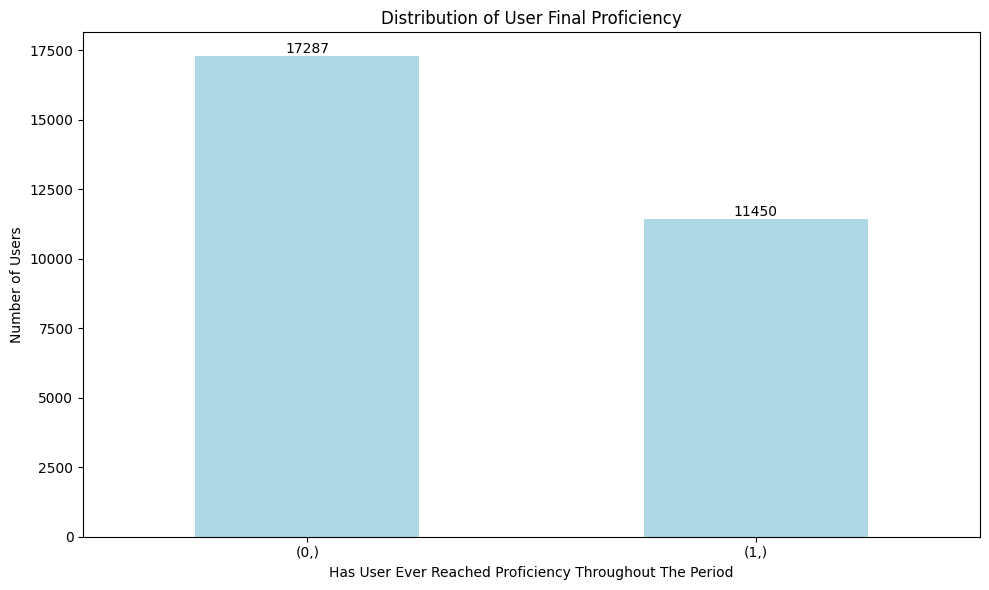

In [ ]:
import matplotlib.pyplot as plt
value_counts = df_user['proficient'].value_counts()
plt.figure(figsize=(10, 6))
bars = value_counts.plot(kind='bar', color='lightblue')
plt.title('Distribution of User Final Proficiency')
plt.xlabel('Has User Ever Reached Proficiency Throughout The Period')
plt.ylabel('Number of Users')
plt.xticks(rotation=0)

for bar in bars.patches:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., yval + 0.1, int(yval), ha='center', va='bottom')
plt.tight_layout()
plt.show()

In [ ]:
#Train, valid, test split for df_user
from sklearn.model_selection import StratifiedShuffleSplit
target = 'proficient'
X = df_user.drop(target, axis=1)
y = df_user[target]
sss_test = StratifiedShuffleSplit(n_splits=1, test_size=0.20, random_state=42)
train_val_idx, test_idx = next(sss_test.split(X, y))

X_train_val, X_test = X.iloc[train_val_idx], X.iloc[test_idx]
y_train_val, y_test = y.iloc[train_val_idx], y.iloc[test_idx]

sss_val = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=42)
train_idx, val_idx = next(sss_val.split(X_train_val, y_train_val))

X_train, X_val = X_train_val.iloc[train_idx], X_train_val.iloc[val_idx]
y_train, y_val = y_train_val.iloc[train_idx], y_train_val.iloc[val_idx]

# Functions Preparation

## GNN

In [ ]:
import numpy as np
import torch
from torch_geometric.data import Data
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from torch_geometric.explain import ModelConfig

def make_graph_tiny(df_raw,*,edge_types=('upid', 'ucid'),stratified_split=True,scale=True,seed=42,train_ratio=0.60,val_ratio=0.20):
    base_cols = [
        'last_activity', 'uuid', 'ucid', 'upid', 'problem_number',
        'exercise_problem_repeat_session', 'is_correct', 'total_sec_taken',
        'total_attempt_cnt', 'is_hint_used','first_login_date_TW', 'user_grade',
        'is_self_coach_x','learning_stage_elementary', 'learning_stage_junior',
        'learning_stage_senior', 'difficulty_easy', 'difficulty_hard',
        'difficulty_normal', 'user_city_encoded',
        'hour', 'day_of_week', 'month', 'year',
        'rolling_login_7d','max_days_since_first_login', 'avg_hints', 'has_teacher',
        'has_student', 'belongs_to_class', 'has_class',
        'avg_weekly_login_freq', 'proficient']
    kept = [c for c in base_cols if c in df_raw.columns]
    df   = df_raw[kept].copy()

    for col in ('upid', 'ucid'):
        if col in df.columns:
            freq = df[col].value_counts()
            df[f'{col}_freq'] = df[col].map(freq).astype(np.float32)
    df.drop(columns=[c for c in ('upid', 'ucid') if c in df.columns], inplace=True)

    num_cols = df.select_dtypes(include=['number', 'bool']).columns.tolist()
    num_cols.remove('proficient')
    if scale and num_cols:
        scaler = StandardScaler()
        df[num_cols] = scaler.fit_transform(df[num_cols]).astype(np.float32)

    g = (df.groupby('uuid', sort=False).agg({**{c: 'mean' for c in num_cols}, 'proficient': 'max'}).reset_index())

    g['node_id']  = np.arange(len(g), dtype=np.int32)
    feat_cols     = [c for c in g.columns if c not in ('uuid', 'proficient', 'node_id')]
    x = torch.tensor(g[feat_cols].to_numpy(dtype=np.float32, copy=False))
    y = torch.tensor(g['proficient'].to_numpy(dtype=np.int64, copy=False))

    node_id  = g['node_id'].to_numpy()
    edge_src = node_id.copy()
    edge_dst = node_id.copy()
    edge_tp  = np.zeros_like(edge_src, dtype=np.int8) # 0=self

    ET, id_maps = {'upid': 1, 'ucid': 2}, {}
    for et in edge_types:
        if et not in df_raw.columns:
            continue
        if et not in id_maps:
            id_maps[et] = (df_raw.drop_duplicates('uuid')
                                     .set_index('uuid')[et])
        g[et] = g['uuid'].map(id_maps[et])

        for _, grp in g.groupby(et, sort=False):
            nodes = grp['node_id'].to_numpy()
            if len(nodes) < 2:
                continue
            hub, others = nodes[0], nodes[1:]
            edge_src = np.concatenate([edge_src,np.repeat(hub, len(others)),others])
            edge_dst = np.concatenate([edge_dst,others,np.repeat(hub, len(others))])
            edge_tp  = np.concatenate([edge_tp,np.full(len(others), ET[et], np.int8),np.full(len(others), ET[et], np.int8)])

    edge_index = torch.as_tensor(np.vstack([edge_src, edge_dst]), dtype=torch.long)
    edge_type  = torch.as_tensor(edge_tp, dtype=torch.int8)
    data = Data(x=x, edge_index=edge_index, edge_type=edge_type, y=y)

    n = data.num_nodes
    data.train_mask = torch.zeros(n, dtype=torch.bool)
    data.val_mask   = torch.zeros(n, dtype=torch.bool)
    data.test_mask  = torch.zeros(n, dtype=torch.bool)

    idx_all = np.arange(n, dtype=np.int32)

    if stratified_split:
        sss_test = StratifiedShuffleSplit(n_splits=1, test_size=0.20, random_state=seed)
        train_val_idx, test_idx = next(sss_test.split(idx_all, y.numpy()))
        sss_val = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=seed)
        train_idx, val_idx = next(sss_val.split(train_val_idx, y[train_val_idx].numpy()))
    else:
        rng   = np.random.default_rng(seed)
        idx   = rng.permutation(n)
        cut1  = int(train_ratio * n)
        cut2  = int((train_ratio + val_ratio) * n)
        train_idx, val_idx, test_idx = idx[:cut1], idx[cut1:cut2], idx[cut2:]

    data.train_mask[torch.as_tensor(train_idx)] = True
    data.val_mask  [torch.as_tensor(val_idx)]   = True
    data.test_mask [torch.as_tensor(test_idx)]  = True

    print(f"Split → train:{data.train_mask.sum().item()}  "
          f"val:{data.val_mask.sum().item()}  "
          f"test:{data.test_mask.sum().item()}")
    return data, feat_cols

def run_experiment_classification(data,model_type,feat_cols,*,hidden_channels=64,lr=1e-3,dropout=0.5,epochs=100,heads=2,do_explain=True):
    import importlib
    has_numpy = importlib.util.find_spec("numpy") is not None

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    data   = copy.deepcopy(data).to(device)
    num_classes = int(data.y.max().item()) + 1

    if model_type == 'GCN':
        model = GCN(hidden_channels, out_channels=num_classes,dropout=dropout).to(device)
    elif model_type == 'GAT':
        model = GAT(hidden_channels, out_channels=num_classes,heads=heads, dropout=dropout).to(device)
    elif model_type == 'GraphSAGE':
        model = GraphSAGE(hidden_channels, out_channels=num_classes).to(device)
    else:
        raise ValueError(f"Unknown model type: {model_type}")

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)
    loss_fn   = nn.CrossEntropyLoss()
    to_list   = lambda t: t.detach().cpu().tolist()

    for epoch in range(1, epochs + 1):
        model.train()
        optimizer.zero_grad()

        out  = model(data.x, data.edge_index)
        loss = loss_fn(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        if epoch % 10 == 0 or epoch == 1:
            with torch.no_grad():
                preds = out[data.train_mask].argmax(dim=1)
                true  = data.y[data.train_mask]

                train_acc = accuracy_score(to_list(true), to_list(preds))
                train_f1_w = f1_score(to_list(true), to_list(preds), average='weighted')
                train_f1_macro = f1_score(to_list(true), to_list(preds), average='macro')
                train_f1_micro = f1_score(to_list(true), to_list(preds), average='micro')

            #print(f"[{model_type}] Epoch {epoch:03d} | " f"Loss: {loss:.4f} | " f"Acc: {train_acc:.4f} | " f"F1-w: {train_f1_w:.4f} | "f"F1-M: {train_f1_macro:.4f} | " f"F1-μ: {train_f1_micro:.4f}")

    model.eval()
    with torch.no_grad():
        out  = model(data.x, data.edge_index)
        pred = out[data.test_mask].argmax(dim=1)
        true = data.y[data.test_mask]

        test_acc = accuracy_score(to_list(true), to_list(pred))
        test_f1  = f1_score(to_list(true), to_list(pred), average='weighted')

    print(f"[{model_type}] Test Acc: {test_acc:.4f} | " f"F1: {test_f1:.4f} | " f"F1 Macro: {train_f1_macro:.4f} | " f"F1 Weighted: {train_f1_w:.4f}")

    node_index = int(data.test_mask.nonzero(as_tuple=True)[0][0])
    explainer = Explainer(
        model=model,
        algorithm=GNNExplainer(epochs=200),
        explanation_type='model',
        node_mask_type='attributes',
        edge_mask_type='object',
        model_config=dict(
            mode='multiclass_classification',
            task_level='node',
            return_type='log_probs'
        ),
    )
    explanation = explainer(data.x, data.edge_index, index=node_index)
    print(f"Available explanations: {explanation.available_explanations}")
    explanation.visualize_feature_importance('feature_importance.png', top_k=10)
    explanation.visualize_graph('subgraph.pdf')
    fig_feat = explanation.visualize_feature_importance(path=None, top_k=10)
    display(fig_feat)

    cm = confusion_matrix(to_list(true), to_list(pred))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix - {model_type}")
    plt.savefig("confusion_matrix.png")
    plt.show()
    return test_acc, test_f1, model, data

_VAL_SPLIT_DONE = False
def objective_classification(trial, model_name, data, args,val_ratio: float = 0.15, seed: int = 42):
    global _VAL_SPLIT_DONE
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    if (not hasattr(data, "val_mask")) or (data.val_mask.sum() == 0):
        if not _VAL_SPLIT_DONE:
            rng = torch.Generator().manual_seed(seed)
            train_idx = data.train_mask.nonzero(as_tuple=True)[0]
            perm      = train_idx[torch.randperm(len(train_idx), generator=rng)]
            cut       = int(len(perm) * (1 - val_ratio))
            new_train, val = perm[:cut], perm[cut:]

            data.train_mask[:]        = False
            data.train_mask[new_train] = True
            data.val_mask             = torch.zeros_like(data.train_mask)
            data.val_mask[val]        = True
            _VAL_SPLIT_DONE = True
        else:
            pass

    hidden_channels = trial.suggest_categorical('hidden_channels', [16, 32, 64])
    lr              = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    dropout         = trial.suggest_float('dropout', 0.2, 0.6)
    num_classes = int(data.y.max().item()) + 1

    if model_name == 'GCN':
        model = GCN(hidden_channels, num_classes, dropout=dropout).to(device)
    elif model_name == 'GAT':
        heads  = getattr(args, "heads", 4)
        model  = GAT(hidden_channels, num_classes, heads=heads,
                     dropout=dropout).to(device)
    elif model_name == 'GraphSAGE':
        model = GraphSAGE(hidden_channels, num_classes).to(device)
    else:
        raise ValueError(f"Unknown model {model_name}")

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)
    loss_fn   = nn.CrossEntropyLoss()
    data_copy = copy.deepcopy(data).to(device)

    best_val_acc = 0.0
    for epoch in range(args.epochs):
        model.train()
        optimizer.zero_grad()
        out  = model(data_copy.x, data_copy.edge_index)
        loss = loss_fn(out[data_copy.train_mask], data_copy.y[data_copy.train_mask])
        loss.backward()
        optimizer.step()
        model.eval()
        with torch.no_grad():
            out_val  = model(data_copy.x, data_copy.edge_index)
            val_pred = out_val[data_copy.val_mask].argmax(dim=1)
            val_true = data_copy.y[data_copy.val_mask]
            val_acc  = (val_pred == val_true).float().mean().item()
            best_val_acc = max(best_val_acc, val_acc)
        trial.report(1 - val_acc, epoch)
        if trial.should_prune():
            raise optuna.TrialPruned()
    del model, optimizer, data_copy
    torch.cuda.empty_cache()
    return 1 - best_val_acc

In [ ]:

class GCN(nn.Module):
    def __init__(self, hidden_channels, out_channels, dropout=0.2):
        super().__init__()
        self.dropout = dropout
        self.conv1 = GraphConv(-1, hidden_channels)
        self.conv2 = GraphConv(-1, out_channels)
        self.dropout_layer = nn.Dropout(p=self.dropout)

    def forward(self, x, edge_index):
        x = self.dropout_layer(x)
        x = self.conv1(x, edge_index).relu()
        x = self.dropout_layer(x)
        x = self.conv2(x, edge_index)
        return x

class GAT(nn.Module):
    def __init__(self, hidden_channels, out_channels, heads=8, dropout=0.1):
        super().__init__()
        self.dropout = dropout
        self.conv1 = GATConv((-1, -1), hidden_channels, heads=heads, dropout=dropout, add_self_loops=False)
        self.conv2 = GATConv((-1, -1), hidden_channels, heads=heads, dropout=dropout, add_self_loops=False)
        self.conv3 = GATConv((-1, -1), out_channels, heads=1, concat=False, dropout=dropout, add_self_loops=False)
        self.norm1 = nn.LayerNorm(hidden_channels * heads)
        self.norm2 = nn.LayerNorm(hidden_channels * heads)

    def forward(self, x, edge_index):
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = self.norm1(x)

        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.elu(x)
        x = self.norm2(x)

        x = self.conv3(x, edge_index)
        return x

class GraphSAGE(nn.Module):
    def __init__(self, hidden_channels, out_channels, dropout=0.2):
        super().__init__()
        self.dropout = dropout
        self.conv1 = SAGEConv((-1, -1), hidden_channels)
        self.conv2 = SAGEConv((-1, -1), out_channels)

    def forward(self, x, edge_index):
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv1(x, edge_index).relu()
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return x

## EvolveGCN

In [ ]:
#used in model training
import numpy as np, pandas as pd, scipy.sparse as sp, copy, torch, random, time
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import (accuracy_score, f1_score, classification_report, confusion_matrix,ConfusionMatrixDisplay)
import torch.nn as nn
from torch.optim import Adam
import matplotlib.pyplot as plt
from torch_geometric.explain import Explainer, GNNExplainer
from torch_geometric.data import Data
from torch_geometric.utils import from_scipy_sparse_matrix
import torch
import torch.nn.functional as F


class EvolveGCNLayerH(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        weight_size = in_dim * out_dim
        self.gru = nn.GRUCell(weight_size, weight_size)

    def forward(self, X, A, prev_weights):
        H = torch.matmul(A, torch.matmul(X, prev_weights))
        prev_flat = prev_weights.view(-1)
        evolved_flat = self.gru(prev_flat.unsqueeze(0), prev_flat.unsqueeze(0))
        evolved = evolved_flat.view(self.in_dim, self.out_dim)
        return H, evolved


class EvolveGCN_H(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        super().__init__()
        self.layer1 = EvolveGCNLayerH(in_dim, hidden_dim)
        self.layer2 = EvolveGCNLayerH(hidden_dim, out_dim)
        self.W1 = nn.Parameter(torch.Tensor(in_dim, hidden_dim))
        self.W2 = nn.Parameter(torch.Tensor(hidden_dim, out_dim))
        nn.init.xavier_uniform_(self.W1)
        nn.init.xavier_uniform_(self.W2)

    def forward(self, X_list, A_list):
        W1 = self.W1
        W2 = self.W2
        for t in range(len(X_list)):
            X = X_list[t]
            A = A_list[t]
            H1, W1 = self.layer1(X, A, W1)
            H1 = F.relu(H1)
            H2, W2 = self.layer2(H1, A, W2)
        return H2

SEED = 42
torch.manual_seed(SEED); np.random.seed(SEED); random.seed(SEED)

'''
class EvolveGCNLayerH(nn.Module):
    def __init__(self, in_dim, out_dim, p_drop=0.1):
        super().__init__()
        self.in_dim, self.out_dim = in_dim, out_dim
        flat = in_dim * out_dim
        self.gru   = nn.GRUCell(flat, flat)
        self.norm  = nn.LayerNorm(out_dim, elementwise_affine=True)
        self.drop  = nn.Dropout(p_drop)

    def forward(self, X, A, W_prev):
        AX   = torch.sparse.mm(A, X)
        H    = AX @ W_prev
        w_flat   = W_prev.reshape(1, -1)
        w_next   = self.gru(w_flat, w_flat).detach()
        W_next   = w_next.view(self.in_dim, self.out_dim)
        H = self.norm(H)
        H = F.relu(H)
        H = self.drop(H)
        return H, W_next


class EvolveGCN_H(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim,p_drop=0.1, freeze_first_layer=False):
        super().__init__()
        self.freeze_first_layer = freeze_first_layer
        self.layer1 = EvolveGCNLayerH(in_dim,    hidden_dim, p_drop)
        self.layer2 = EvolveGCNLayerH(hidden_dim, out_dim,   p_drop)
        self.W1 = nn.Parameter(torch.empty(in_dim,    hidden_dim))
        self.W2 = nn.Parameter(torch.empty(hidden_dim, out_dim))
        nn.init.xavier_uniform_(self.W1)
        nn.init.xavier_uniform_(self.W2)
    def forward(self, X_seq, A_seq):
        W1, W2 = self.W1, self.W2
        for X, A in zip(X_seq, A_seq):
            if self.freeze_first_layer:
                H1 = torch.sparse.mm(A, X) @ W1
            else:
                H1, W1 = self.layer1(X, A, W1)
            H2, W2 = self.layer2(H1, A, W2)
        return H2
'''

def _normalize_sparse(adj: sp.spmatrix) -> sp.csr_matrix:
    adj = adj + sp.eye(adj.shape[0], dtype=np.float32, format='csr')
    rowsum = np.asarray(adj.sum(1)).ravel()
    inv_sqrt = np.power(rowsum, -0.5, where=rowsum != 0).astype(np.float32)
    D_inv_sqrt = sp.diags(inv_sqrt)
    return D_inv_sqrt @ adj @ D_inv_sqrt

def _csr_to_torch_sparse(mat: sp.csr_matrix, device='cpu'):
    coo = mat.tocoo()
    idx = torch.vstack((torch.tensor(coo.row), torch.tensor(coo.col))).long()
    vals = torch.tensor(coo.data, dtype=torch.float32)
    return torch.sparse_coo_tensor(idx, vals, size=coo.shape,device=device).coalesce()

def build_snapshots_fast(df,time_col='timestamp_TW',uuid_col='uuid',label_col='proficient',snapshot_freq='W',feature_cols=None,edge_builder='self',knn_k=5,dropna=True,label_all=True):
    df = df.copy()
    df[time_col] = pd.to_datetime(df[time_col])
    df['snapshot'] = df[time_col].dt.to_period(snapshot_freq).dt.to_timestamp()

    if feature_cols is None:
        feature_cols = df.select_dtypes(['number', 'bool']).columns

    df[feature_cols] = df[feature_cols].astype(np.float32)
    enc = LabelEncoder()
    df['uid'] = enc.fit_transform(df[uuid_col])

    max_t = df['snapshot'].max()
    snapshots = []
    for t, grp in df.groupby('snapshot', sort=False):
        node_ids = np.sort(grp['uid'].unique())
        n = len(node_ids)

        # adjacency
        if edge_builder == 'self':
            adj = sp.identity(n, dtype=np.float32, format='csr')
        else:
            Xmean = (grp.groupby('uid')[feature_cols]
                       .mean()
                       .reindex(node_ids)
                       .fillna(0)
                       .to_numpy(np.float32))
            nbrs = NearestNeighbors(n_neighbors=min(knn_k+1, n)).fit(Xmean)
            _, neigh = nbrs.kneighbors(Xmean)
            row = np.repeat(np.arange(n), knn_k)
            col = neigh[:, 1:].reshape(-1)
            adj = sp.coo_matrix((np.ones_like(row, dtype=np.float32),
                                 (row, col)), shape=(n, n)).tocsr()
            adj = adj + adj.T
            adj.data[:] = 1.0
            adj = _normalize_sparse(adj)
        if edge_builder == 'self':
            adj = _normalize_sparse(adj)

        # features
        feats = (grp.groupby('uid')[feature_cols]
                 .mean()
                 .reindex(node_ids)
                 .fillna(0)
                 .to_numpy(np.float32))
        if dropna and np.isnan(feats).any():
            continue

        # labels
        if label_all or t == max_t:
            y = (grp.groupby('uid')[label_col]
                   .first()
                   .reindex(node_ids)
                   .to_numpy())
        else:
            y = None

        snapshots.append(dict(time=t, adj=adj, features=feats,
                              node_ids=node_ids, labels=y))
    return snapshots, enc


def split_snapshots_time(snapshots, train_ratio=0.6, val_ratio=0.2):
    total = len(snapshots)
    train_end = int(total*train_ratio)
    val_end   = int(total*(train_ratio+val_ratio))
    return snapshots[:train_end], snapshots[:val_end], snapshots  # train, train+val, all(test)

class _LastStepWrapper(nn.Module):
    def __init__(self, evolvegcn):
        super().__init__()
        self.evgcn = evolvegcn
    def forward(self, data: Data):
        x, ei = data.x, data.edge_index
        n = x.size(0)
        A = torch.sparse_coo_tensor(ei, torch.ones(ei.size(1), device=x.device),
                                    (n, n)).coalesce()
        return self.evgcn([x], [A])

def explain_node_features(wrapper, snapshot, feature_names,node_idx=None, topk=10, device='cpu'):
    X = torch.tensor(snapshot['features'], dtype=torch.float32, device=device)
    ei, _ = from_scipy_sparse_matrix(snapshot['adj'])
    ei = ei.to(device)
    data = Data(x=X, edge_index=ei)
    if node_idx is None:
        node_idx = np.random.randint(0, X.size(0))

    explainer = Explainer(
    model=wrapper,
    algorithm=GNNExplainer(epochs=200),
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type=None,
    model_config=dict(
        mode='binary_classification',
        task_level='node',
        return_type='raw')
    )

    exp = explainer(x=data.x, edge_index=data.edge_index, index=node_idx)
    mask = exp.get('node_feat_mask').detach().cpu().numpy()
    top_idx = mask.argsort()[::-1][:topk]
    print(f"\n GNNExplainer – node {node_idx}  (Top {topk} features)")
    print("-"*50)
    for r,i in enumerate(top_idx,1):
        print(f"{r:02d}. {feature_names[i]:<30}  importance = {mask[i]:.4f}")
    print("-"*50)

def run_evolvegcn_experiment(snapshots,feature_names,hidden_dim,lr,epochs=500,patience=30,train_ratio=0.6,val_ratio=0.2,explain=False,explain_k=10,node_idx=None,verbose_every=20):

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    train_s, val_s, test_s = split_snapshots_time(snapshots, train_ratio, val_ratio)

    def tensors(snaps):
        X, A = [], []
        for s in snaps:
            X.append(torch.tensor(s['features'], dtype=torch.float32, device=device))
            A.append(_csr_to_torch_sparse(s['adj'], device=device))
        return X, A
    Xtr, Atr = tensors(train_s)
    Xv , Av  = tensors(val_s)
    Xte, Ate = tensors(test_s)

    ytr = torch.tensor(train_s[-1]['labels'], dtype=torch.long, device=device)
    yv  = torch.tensor(val_s [-1]['labels'],  dtype=torch.long, device=device)
    yte = torch.tensor(test_s[-1]['labels'],  dtype=torch.long, device=device)

    num_cls = int(max(ytr.max(), yv.max(), yte.max()).item()) + 1
    model   = EvolveGCN_H(Xtr[0].shape[1], hidden_dim, num_cls).to(device)
    opt     = Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()

    best_val, best_w, no_gain = 0., None, 0
    to_np = lambda t: t.detach().cpu().numpy()

    for ep in range(1, epochs+1):
        model.train(); opt.zero_grad()
        loss = loss_fn(model(Xtr, Atr), ytr); loss.backward(); opt.step()

        model.eval()
        with torch.no_grad():
            val_pred = model(Xv, Av).argmax(1)
        val_acc = accuracy_score(to_np(yv), to_np(val_pred))

        if val_acc > best_val:
            best_val, best_w = val_acc, copy.deepcopy(model.state_dict())
            no_gain = 0
        else:
            no_gain += 1
            if no_gain >= patience:
                print(f"Early-stop @ {ep}")
                break
        if ep%verbose_every==0 or ep==1:
            print(f"[Ep {ep:04d}] loss {loss:.4f} | val-acc {val_acc:.4f}")
    model.load_state_dict(best_w)
    model.eval()
    with torch.no_grad():
        test_logits = model(Xte, Ate); test_pred = test_logits.argmax(1)
    acc  = accuracy_score(to_np(yte), to_np(test_pred))
    f1w  = f1_score(to_np(yte), to_np(test_pred), average='weighted')
    f1m  = f1_score(to_np(yte), to_np(test_pred), average='macro')
    print("\n===== Final Test =====")
    print(classification_report(to_np(yte), to_np(test_pred), digits=4))
    print(f"Acc {acc:.4f} | F1w {f1w:.4f} | F1m {f1m:.4f}")

    cm = confusion_matrix(to_np(yte), to_np(test_pred))
    ConfusionMatrixDisplay(cm).plot(cmap=plt.cm.Blues); plt.title("Confusion Matrix"); plt.show()
    if explain:
        wrapper = _LastStepWrapper(model).to(device)
        explain_node_features(wrapper, test_s[-1],
                              feature_names=feature_names,
                              node_idx=node_idx,
                              topk=explain_k,
                              device=device)

In [ ]:
def objective_evolvegcn(trial, snapshots, num_classes):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    hidden_dim = trial.suggest_categorical("hidden_dim", [32, 64, 128])
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)

    X_list = [torch.tensor(s['features'], dtype=torch.float32).to(device) for s in snapshots]
    A_list = [torch.tensor(s['adj'].todense(), dtype=torch.float32).to(device) for s in snapshots]
    final_labels = torch.tensor(snapshots[-1]['labels'], dtype=torch.long).to(device)

    model = EvolveGCN_H(X_list[0].shape[1], hidden_dim, num_classes).to(device)
    optimizer = Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()

    best_acc = 0
    for epoch in range(30):
        model.train()
        optimizer.zero_grad()
        out = model(X_list, A_list)
        loss = loss_fn(out, final_labels)
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            preds = out.argmax(dim=1)
            acc = accuracy_score(final_labels.cpu(), preds.cpu())
            if acc > best_acc:
                best_acc = acc

    del model
    torch.cuda.empty_cache()
    return best_acc


def run_optuna_evolvegcn(snapshots, num_classes, n_trials=20):
    study = optuna.create_study(direction="maximize")
    study.optimize(lambda trial: objective_evolvegcn(trial, snapshots, num_classes), n_trials=n_trials)
    print("Best params:", study.best_params)
    return study.best_params

# Experiment

## Majority Baseline

In [ ]:
#majority baseline
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report
zero_r = DummyClassifier(strategy="most_frequent")
zero_r.fit(X_train, y_train)
y_pred = zero_r.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.60      1.00      0.75      3458
           1       0.00      0.00      0.00      2290

    accuracy                           0.60      5748
   macro avg       0.30      0.50      0.38      5748
weighted avg       0.36      0.60      0.45      5748



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## RF

In [ ]:
'''
# === Hyperparameter Tuning on Sample (5%) ===
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from scipy import stats

df_sampled = df.sample(frac=0.01, random_state=42)
X_sample = df_sampled.drop(columns=drop_cols)
y_sample = df_sampled['points']
X_sample_train, X_sample_val, y_sample_train, y_sample_val = train_test_split(
    X_sample, y_sample, test_size=0.3, random_state=42,)
rf_model = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [6, 10],
    'max_features': ['sqrt']
}
grid_search = GridSearchCV(rf_model,param_grid=param_grid,cv=2,scoring='accuracy',n_jobs=1)
grid_search.fit(X_sample_train, y_sample_train)
best_params = grid_search.best_params_
print("Best Hyperparameters Found:", best_params)
'''

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(


Best Hyperparameters Found: {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 100}


### Try 6

Test
Accuracy:0.808
F1 (macro):0.794
F1 (weighted):0.805
ROC-AUC: 0.884

Classification report
               precision    recall  f1-score   support

           0       0.81      0.89      0.85      3458
           1       0.80      0.69      0.74      2290

    accuracy                           0.81      5748
   macro avg       0.81      0.79      0.79      5748
weighted avg       0.81      0.81      0.80      5748



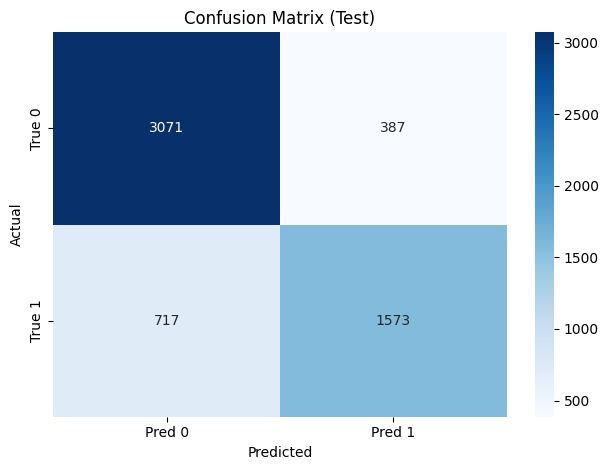

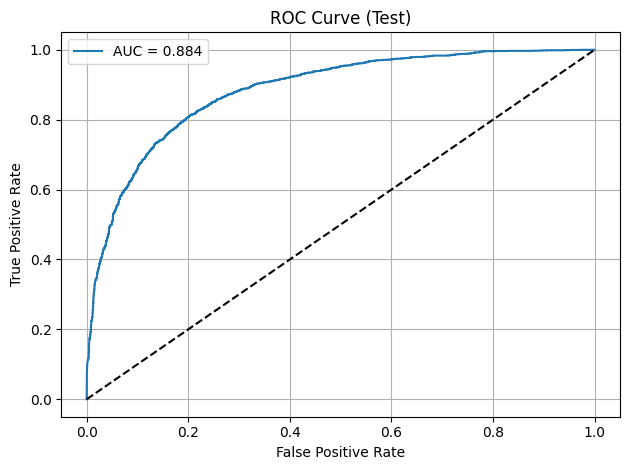

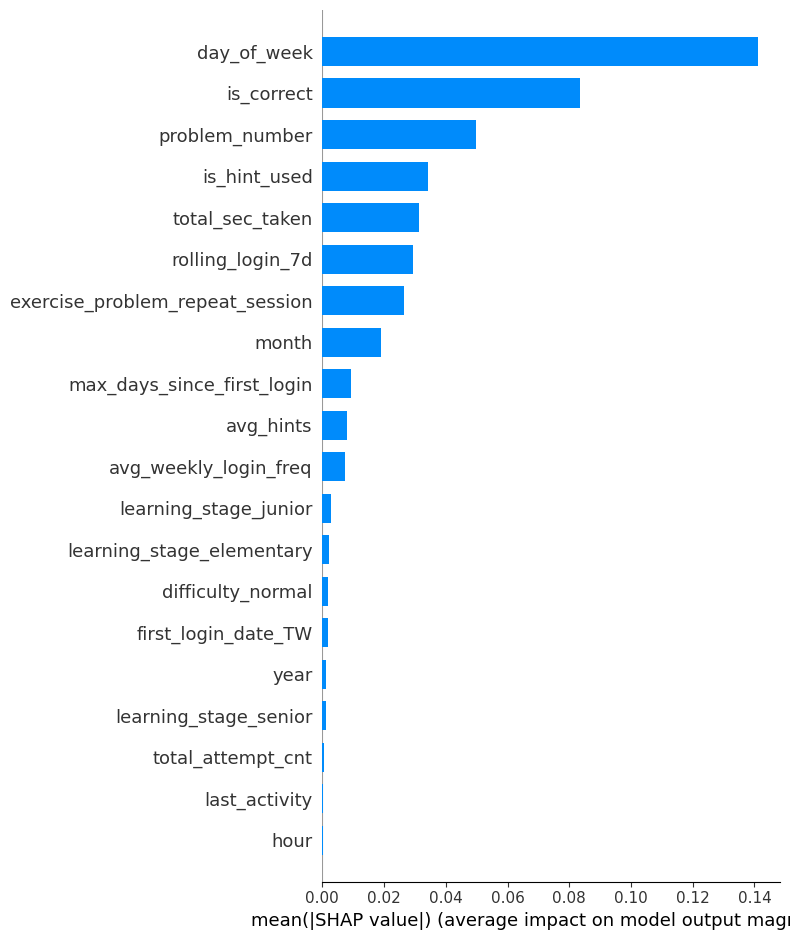

In [ ]:
#take this for result
rf = RandomForestClassifier(max_depth=10,max_features=0.5,n_estimators=100,min_samples_leaf=5,bootstrap=True,n_jobs=-1,random_state=42)
rf.fit(X_train, y_train)
y_val_pred  = rf.predict(X_val)
y_val_proba = rf.predict_proba(X_val)[:, 1]
y_test_pred  = rf.predict(X_test)
y_test_proba = rf.predict_proba(X_test)[:, 1]

print("Test")
print(f"Accuracy:{accuracy_score(y_test, y_test_pred):.3f}")
print(f"F1 (macro):{f1_score(y_test, y_test_pred, average='macro'):.3f}")
print(f"F1 (weighted):{f1_score(y_test, y_test_pred, average='weighted'):.3f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_test_proba):.3f}\n")
print("Classification report\n", classification_report(y_test, y_test_pred))

cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',xticklabels=['Pred 0', 'Pred 1'],yticklabels=['True 0', 'True 1'])
plt.xlabel('Predicted'); plt.ylabel('Actual')
plt.title('Confusion Matrix (Test)'); plt.tight_layout(); plt.show()

fpr, tpr, _ = roc_curve(y_test, y_test_proba)
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_test, y_test_proba):.3f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Test)'); plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

if X_test.shape[0] < X_test.shape[1]:
    X_test = X_test.T
if isinstance(X_test.columns, pd.MultiIndex):
    X_test.columns = ['{}_{}'.format(a, b) if b else str(a) for a, b in X_test.columns]
explainer = shap.TreeExplainer(rf, model_output="raw")
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values[:, :, 1], features=X_test, feature_names=X_test.columns, plot_type='bar')

Test
Accuracy:0.833
F1 (macro):0.823
F1 (weighted):0.832
ROC-AUC: 0.905

Classification report
               precision    recall  f1-score   support

           0       0.85      0.88      0.86      3458
           1       0.81      0.76      0.78      2290

    accuracy                           0.83      5748
   macro avg       0.83      0.82      0.82      5748
weighted avg       0.83      0.83      0.83      5748



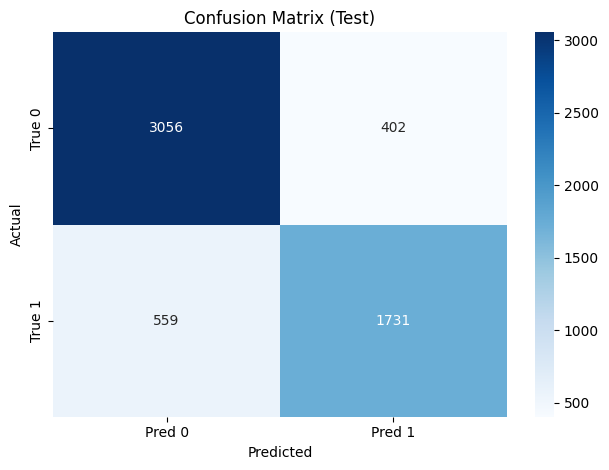

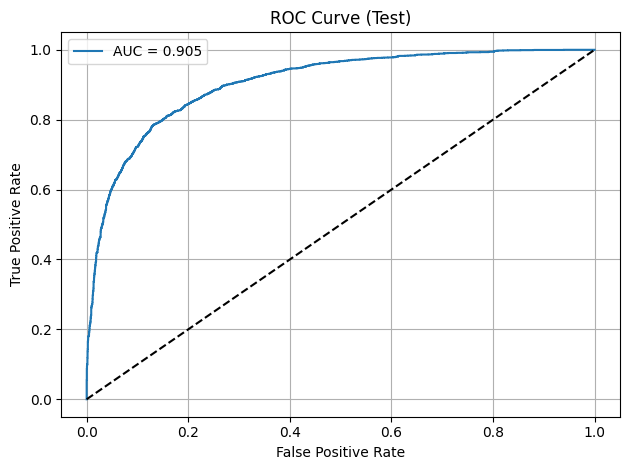

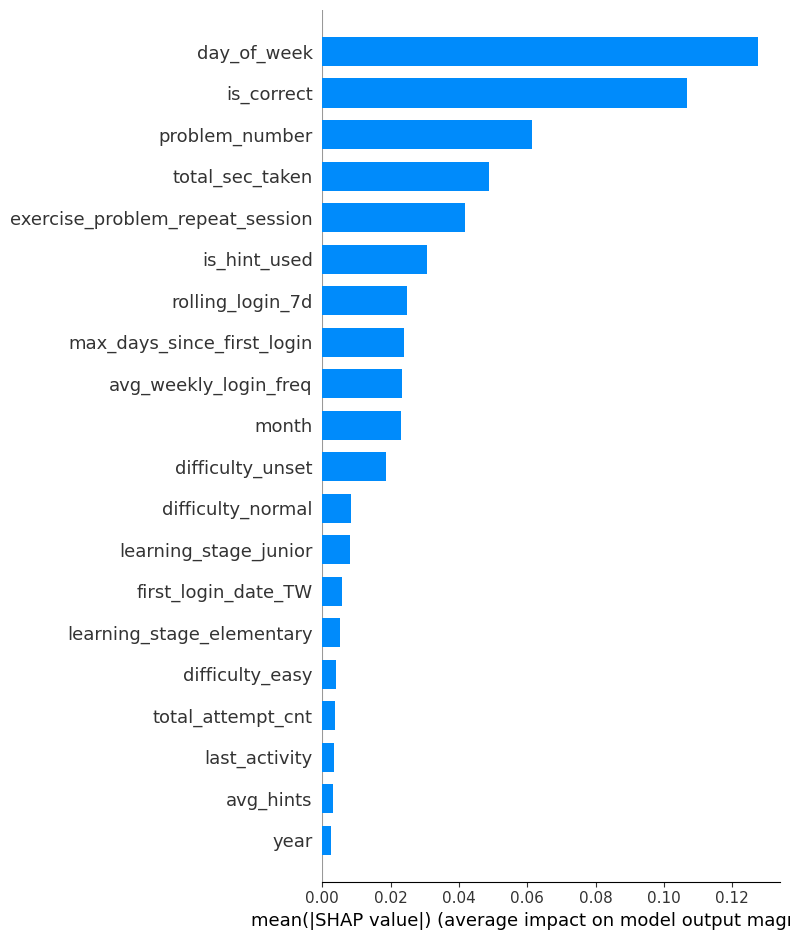

In [ ]:
rf = RandomForestClassifier(max_depth=10,max_features=0.5,n_estimators=50,min_samples_leaf=5,bootstrap=True,n_jobs=-1,random_state=42)
rf.fit(X_train, y_train)
y_val_pred  = rf.predict(X_val)
y_val_proba = rf.predict_proba(X_val)[:, 1]
y_test_pred  = rf.predict(X_test)
y_test_proba = rf.predict_proba(X_test)[:, 1]

print("Test")
print(f"Accuracy:{accuracy_score(y_test, y_test_pred):.3f}")
print(f"F1 (macro):{f1_score(y_test, y_test_pred, average='macro'):.3f}")
print(f"F1 (weighted):{f1_score(y_test, y_test_pred, average='weighted'):.3f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_test_proba):.3f}\n")
print("Classification report\n", classification_report(y_test, y_test_pred))

cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',xticklabels=['Pred 0', 'Pred 1'],yticklabels=['True 0', 'True 1'])
plt.xlabel('Predicted'); plt.ylabel('Actual')
plt.title('Confusion Matrix (Test)'); plt.tight_layout(); plt.show()

fpr, tpr, _ = roc_curve(y_test, y_test_proba)
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_test, y_test_proba):.3f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Test)'); plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

if X_test.shape[0] < X_test.shape[1]:
    X_test = X_test.T
if isinstance(X_test.columns, pd.MultiIndex):
    X_test.columns = ['{}_{}'.format(a, b) if b else str(a) for a, b in X_test.columns]
explainer = shap.TreeExplainer(rf, model_output="raw")
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values[:, :, 1], features=X_test, feature_names=X_test.columns, plot_type='bar')

### Try 5(no leakage)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


========  Test (20 %)  ========
Accuracy       : 0.833
F1 (macro)     : 0.823
F1 (weighted)  : 0.832
ROC-AUC        : 0.907

Classification report
               precision    recall  f1-score   support

           0       0.84      0.89      0.87      3458
           1       0.82      0.75      0.78      2290

    accuracy                           0.83      5748
   macro avg       0.83      0.82      0.82      5748
weighted avg       0.83      0.83      0.83      5748



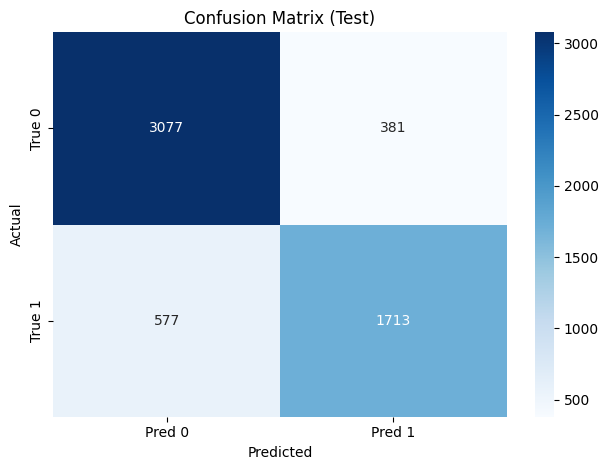

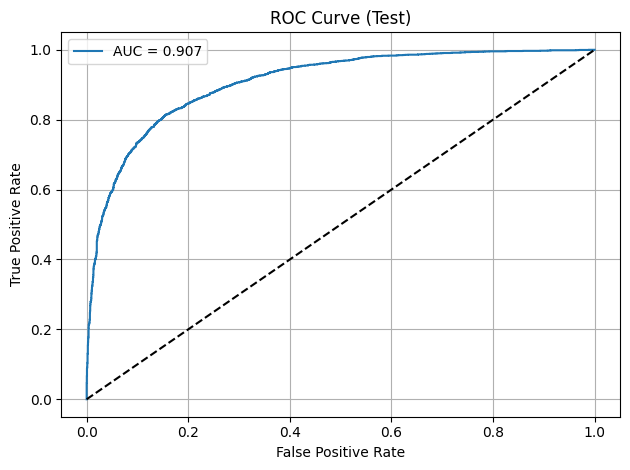

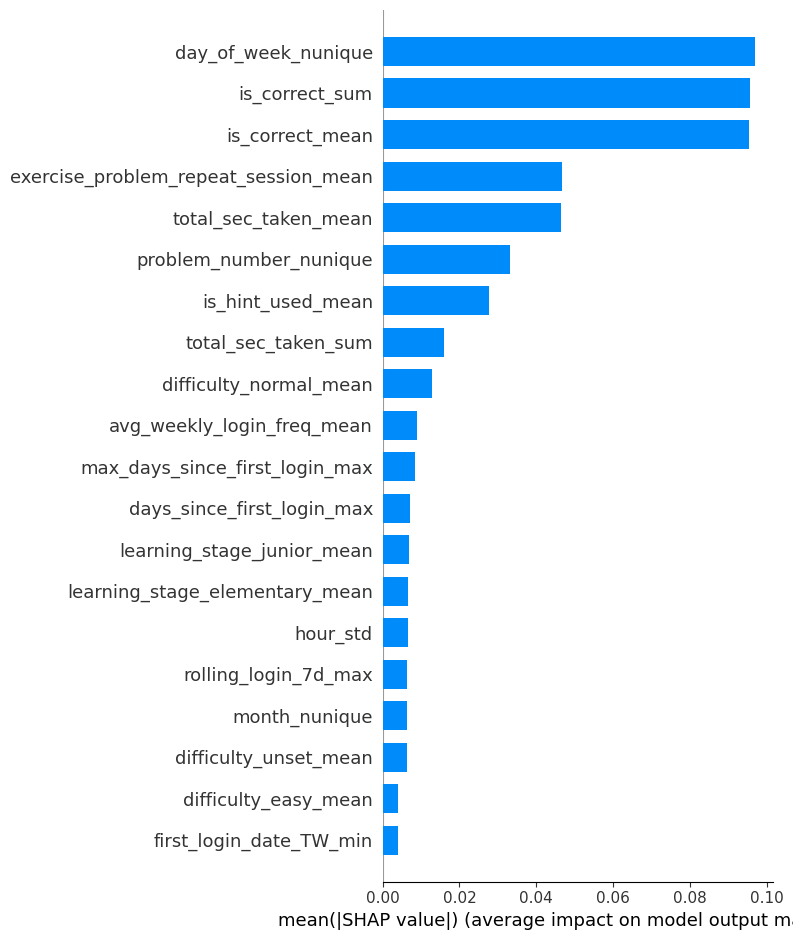

In [ ]:
rf = RandomForestClassifier(max_depth=10,max_features=0.5,n_estimators=50,min_samples_leaf=5,bootstrap=True,n_jobs=-1,random_state=42)
rf.fit(X_train, y_train)
y_val_pred  = rf.predict(X_val)
y_val_proba = rf.predict_proba(X_val)[:, 1]
y_test_pred  = rf.predict(X_test)
y_test_proba = rf.predict_proba(X_test)[:, 1]

print("========  Test (20 %)  ========")
print(f"Accuracy       : {accuracy_score(y_test, y_test_pred):.3f}")
print(f"F1 (macro)     : {f1_score(y_test, y_test_pred, average='macro'):.3f}")
print(f"F1 (weighted)  : {f1_score(y_test, y_test_pred, average='weighted'):.3f}")
print(f"ROC-AUC        : {roc_auc_score(y_test, y_test_proba):.3f}\n")
print("Classification report\n", classification_report(y_test, y_test_pred))

cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pred 0', 'Pred 1'],
            yticklabels=['True 0', 'True 1'])
plt.xlabel('Predicted'); plt.ylabel('Actual')
plt.title('Confusion Matrix (Test)'); plt.tight_layout(); plt.show()

fpr, tpr, _ = roc_curve(y_test, y_test_proba)
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_test, y_test_proba):.3f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Test)'); plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

if X_test.shape[0] < X_test.shape[1]:
    X_test = X_test.T
if isinstance(X_test.columns, pd.MultiIndex):
    X_test.columns = ['{}_{}'.format(a, b) if b else str(a) for a, b in X_test.columns]
explainer = shap.TreeExplainer(rf, model_output="raw")
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values[:, :, 1], features=X_test, feature_names=X_test.columns, plot_type='bar')

### Try 4

In [ ]:
rf = RandomForestClassifier(max_depth=10,max_features=0.5,n_estimators=50,min_samples_leaf=5,bootstrap=True,n_jobs=-1,random_state=42)
y_train = y_train.squeeze()
rf.fit(X_train, y_train)
y_val_pred  = rf.predict(X_val)
y_val_proba = rf.predict_proba(X_val)[:, 1]
y_test_pred  = rf.predict(X_test)
y_test_proba = rf.predict_proba(X_test)[:, 1]
# SHAP
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)
shap.initjs()
X_test_enc = X_test.to_numpy()
feature_names = X_test.columns
#shap.summary_plot(shap_values[1],features=X_test_enc,feature_names = feature_names,plot_type='bar')

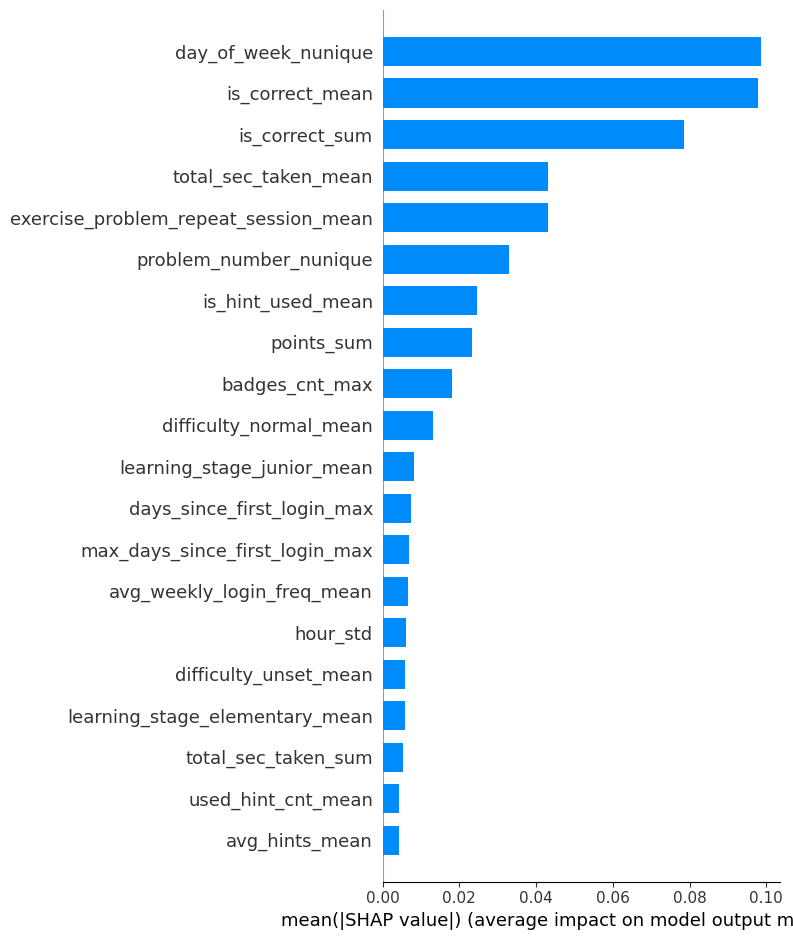

IndexError: index 1 is out of bounds for axis 0 with size 1

In [ ]:

# 假設 X_test shape 目前是 (42, 5748)，先轉置回正確格式
if X_test.shape[0] < X_test.shape[1]:
    X_test = X_test.T

# 如果 columns 是 MultiIndex，轉成普通 column name
if isinstance(X_test.columns, pd.MultiIndex):
    X_test.columns = ['{}_{}'.format(a, b) if b else str(a) for a, b in X_test.columns]

# 再確認 shape
print("X_test shape:", X_test.shape)

# 建立 SHAP explainer
explainer = shap.TreeExplainer(rf, model_output="raw")
shap_values = explainer.shap_values(X_test)

# Summary plot
shap.summary_plot(shap_values[:, :, 1], features=X_test, feature_names=X_test.columns, plot_type='bar')

# 取單一 instance 來畫 force plot
choosen_instance = X_test.iloc[[10]]  # 例如第10筆
instance_shap_values = explainer.shap_values(choosen_instance)
shap.initjs()
shap.force_plot(explainer.expected_value[1], instance_shap_values[1], choosen_instance)


In [ ]:
print(shap_values.shape)
print(X_test)

(5748, 42, 2)
        uuid  timestamp_TW_max  first_login_date_TW_min  days_since_first_login_max  rolling_login_7d_max  max_days_since_first_login_max  problem_number_nunique  exercise_problem_repeat_session_mean  is_correct_mean  is_correct_sum  total_sec_taken_mean  total_sec_taken_sum  total_attempt_cnt_mean  used_hint_cnt_mean  is_hint_used_mean    points_sum  badges_cnt_max  avg_hints_mean  avg_weekly_login_freq_mean  has_teacher_cnt_max  has_student_cnt_max  belongs_to_class_cnt_max  has_class_cnt_max  is_self_coach_x_max  has_teacher_max  has_student_max  belongs_to_class_max  has_class_max  learning_stage_elementary_mean  learning_stage_junior_mean  learning_stage_senior_mean  difficulty_easy_mean  difficulty_normal_mean  difficulty_hard_mean  difficulty_unset_mean  hour_mean  hour_std  day_of_week_nunique  month_nunique  year_nunique  user_grade_last  user_city_encoded_last
7668    7668             20160                       90                         156                  92

### Try 3

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, confusion_matrix,classification_report
rf_model = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [25,50,100],
    'max_depth': [2,4,6,8,10],
    'max_features': ['sqrt']
}
grid_search = GridSearchCV(rf_model,param_grid=param_grid,cv=2,scoring='accuracy',n_jobs=1)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print("Best Hyperparameters Found:", best_params)

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example usi

Best Hyperparameters Found: {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 50}


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


========  Test (20 %)  ========
Accuracy       : 0.834
F1 (macro)     : 0.824
F1 (weighted)  : 0.832
ROC-AUC        : 0.908

Classification report
               precision    recall  f1-score   support

           0       0.84      0.89      0.87      3458
           1       0.82      0.75      0.78      2290

    accuracy                           0.83      5748
   macro avg       0.83      0.82      0.82      5748
weighted avg       0.83      0.83      0.83      5748



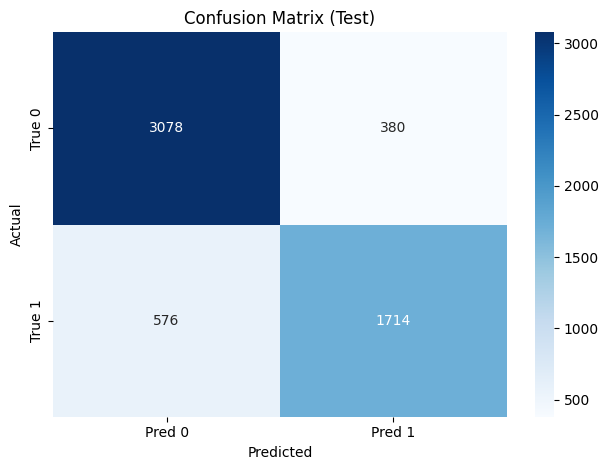

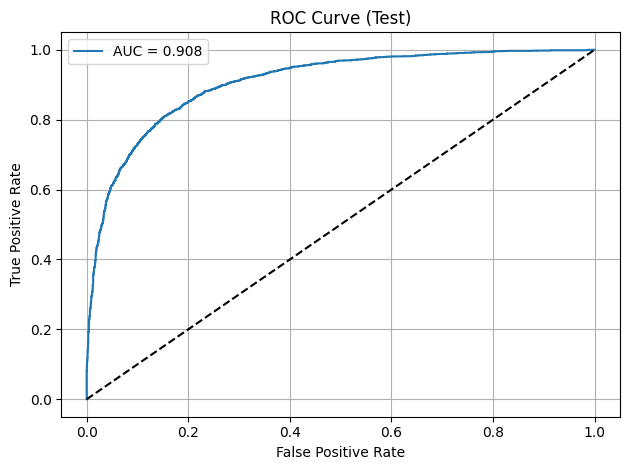

In [ ]:
rf = RandomForestClassifier(max_depth=10,max_features=0.5,n_estimators=50,min_samples_leaf=5,bootstrap=True,n_jobs=-1,random_state=42)
rf.fit(X_train, y_train)
y_val_pred  = rf.predict(X_val)
y_val_proba = rf.predict_proba(X_val)[:, 1]
y_test_pred  = rf.predict(X_test)
y_test_proba = rf.predict_proba(X_test)[:, 1]

print("========  Test (20 %)  ========")
print(f"Accuracy       : {accuracy_score(y_test, y_test_pred):.3f}")
print(f"F1 (macro)     : {f1_score(y_test, y_test_pred, average='macro'):.3f}")
print(f"F1 (weighted)  : {f1_score(y_test, y_test_pred, average='weighted'):.3f}")
print(f"ROC-AUC        : {roc_auc_score(y_test, y_test_proba):.3f}\n")
print("Classification report\n", classification_report(y_test, y_test_pred))

cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pred 0', 'Pred 1'],
            yticklabels=['True 0', 'True 1'])
plt.xlabel('Predicted'); plt.ylabel('Actual')
plt.title('Confusion Matrix (Test)'); plt.tight_layout(); plt.show()

fpr, tpr, _ = roc_curve(y_test, y_test_proba)
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_test, y_test_proba):.3f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Test)'); plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()


### Try 2

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Accuracy       : 0.839
F1 (macro)     : 0.829
F1 (weighted)  : 0.837
ROC-AUC        : 0.914

Classification report
               precision    recall  f1-score   support

           0       0.85      0.90      0.87      5187
           1       0.83      0.75      0.79      3435

    accuracy                           0.84      8622
   macro avg       0.84      0.82      0.83      8622
weighted avg       0.84      0.84      0.84      8622



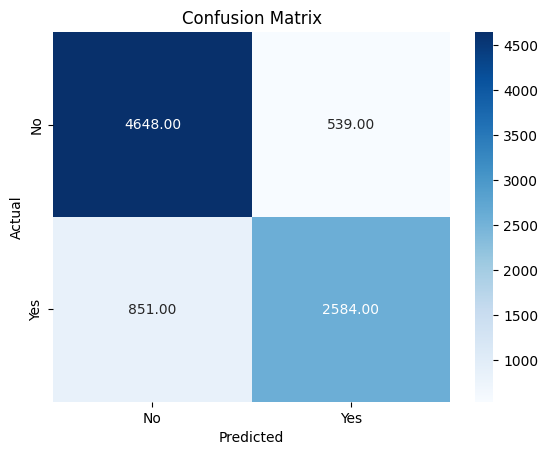

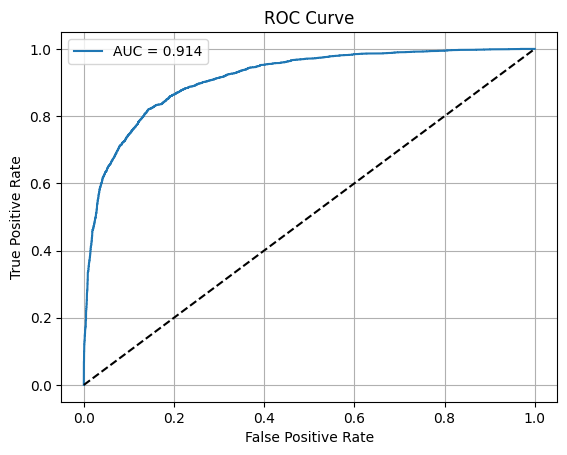

In [ ]:
rf = RandomForestClassifier(max_depth=10,max_features=0.5,n_estimators=100,min_samples_leaf=5,bootstrap=True,n_jobs=-1,random_state=42)

rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)[:, 1]
print(f"\nAccuracy       : {accuracy_score(y_test, y_pred):.3f}")
print(f"F1 (macro)     : {f1_score(y_test, y_pred, average='macro'):.3f}")
print(f"F1 (weighted)  : {f1_score(y_test, y_pred, average='weighted'):.3f}")
print(f"ROC-AUC        : {roc_auc_score(y_test, y_proba):.3f}\n")
print("Classification report\n", classification_report(y_test, y_pred))

# confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.xlabel('Predicted'); plt.ylabel('Actual')
plt.title('Confusion Matrix'); plt.show()

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_test, y_proba):.3f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('ROC Curve'); plt.legend(); plt.grid(True); plt.show()

### Try 1

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Accuracy       : 0.839
F1 (macro)     : 0.829
F1 (weighted)  : 0.837
ROC-AUC        : 0.914

Classification report
               precision    recall  f1-score   support

           0       0.85      0.90      0.87      5187
           1       0.83      0.75      0.79      3435

    accuracy                           0.84      8622
   macro avg       0.84      0.82      0.83      8622
weighted avg       0.84      0.84      0.84      8622



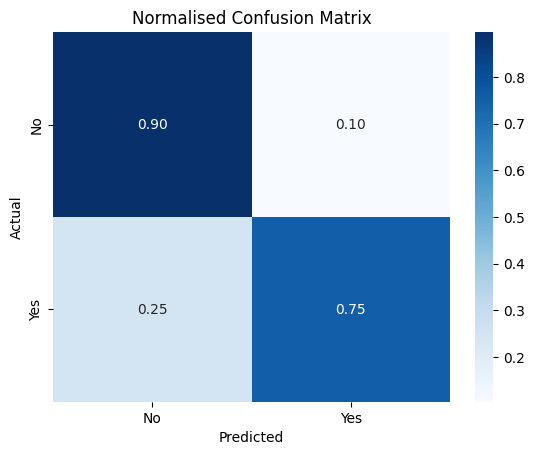

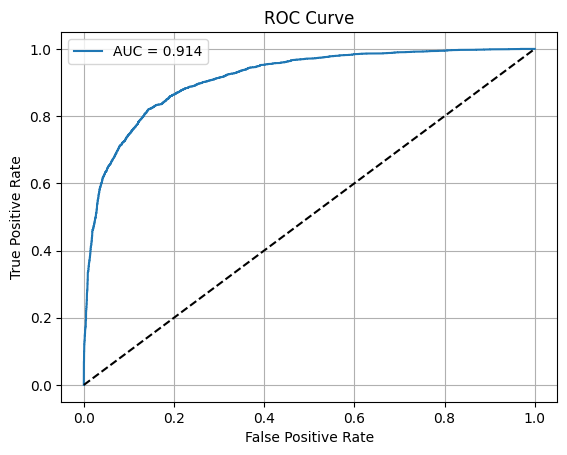

In [ ]:
rf = RandomForestClassifier(max_depth=10,max_features=0.5,n_estimators=100,min_samples_leaf=5,bootstrap=True,n_jobs=-1,random_state=42)

rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)[:, 1]
print(f"\nAccuracy       : {accuracy_score(y_test, y_pred):.3f}")
print(f"F1 (macro)     : {f1_score(y_test, y_pred, average='macro'):.3f}")
print(f"F1 (weighted)  : {f1_score(y_test, y_pred, average='weighted'):.3f}")
print(f"ROC-AUC        : {roc_auc_score(y_test, y_proba):.3f}\n")
print("Classification report\n", classification_report(y_test, y_pred))

# confusion matrix
cm = confusion_matrix(y_test, y_pred, normalize='true')
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.xlabel('Predicted'); plt.ylabel('Actual')
plt.title('Normalised Confusion Matrix'); plt.show()

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_test, y_proba):.3f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('ROC Curve'); plt.legend(); plt.grid(True); plt.show()

In [ ]:
# SHAP
'''
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test, check_additivity=False)
X_test_enc = X_test.to_numpy()
feature_names = X_test.columns
shap.summary_plot(shap_values[1],features=X_test_enc,feature_names = feature_names,plot_type='bar')
'''

"\nexplainer = shap.TreeExplainer(rf)\nshap_values = explainer.shap_values(X_test, check_additivity=False)\nX_test_enc = X_test.to_numpy()  \nfeature_names = X_test.columns\nshap.summary_plot(shap_values[1],features=X_test_enc,feature_names = feature_names,plot_type='bar')\n"

## GNN

In [ ]:
feat_cols

['problem_number',
 'exercise_problem_repeat_session',
 'is_correct',
 'total_sec_taken',
 'total_attempt_cnt',
 'is_hint_used',
 'user_grade',
 'is_self_coach_x',
 'learning_stage_elementary',
 'learning_stage_junior',
 'learning_stage_senior',
 'difficulty_easy',
 'difficulty_hard',
 'difficulty_normal',
 'user_city_encoded',
 'hour',
 'day_of_week',
 'month',
 'year',
 'rolling_login_7d',
 'max_days_since_first_login',
 'avg_hints',
 'has_teacher',
 'has_student',
 'belongs_to_class',
 'has_class',
 'avg_weekly_login_freq',
 'upid_freq',
 'ucid_freq']

### Result

[GCN] Test Acc: 0.8154 | F1: 0.8169 | F1 Macro: 0.7893 | F1 Weighted: 0.7948
Available explanations: ['node_mask', 'edge_mask']


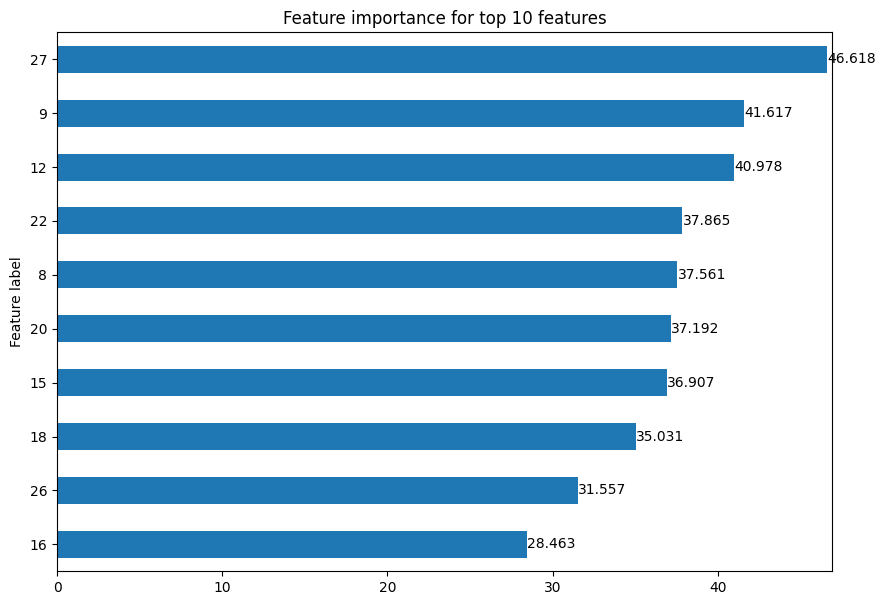

None

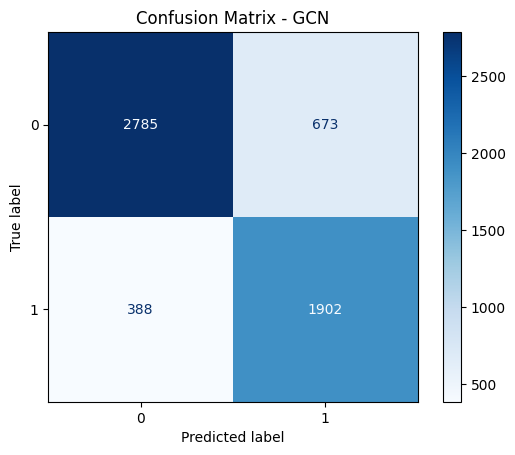

In [ ]:
#GCN 2
#keep this result
test_acc, test_f1, model, _ = run_experiment_classification(data,'GCN',feat_cols,hidden_channels=64,lr=0.008523295510961308,dropout=0.23044751904196414,epochs=500)

[GAT] Test Acc: 0.7055 | F1: 0.7058 | F1 Macro: 0.6504 | F1 Weighted: 0.6640
Available explanations: ['node_mask', 'edge_mask']


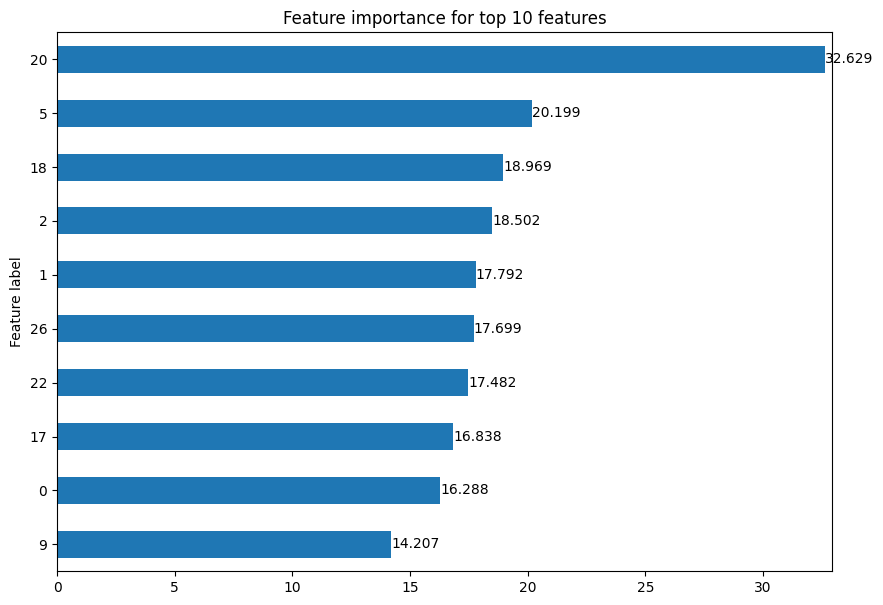

None

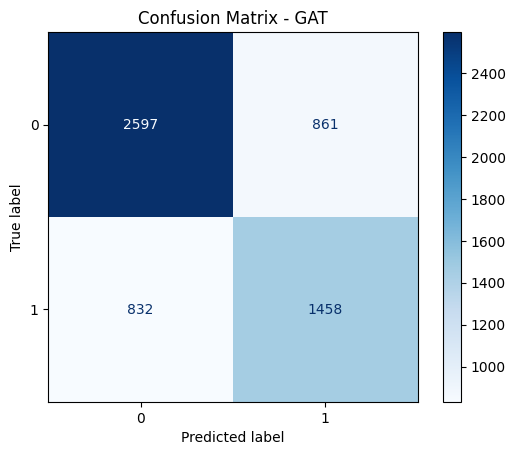

In [ ]:
#GAT 2
#keep this as result
test_acc, test_f1, model, _ = run_experiment_classification(data,'GAT',feat_cols,hidden_channels=32,lr=0.00529352947539645,dropout=0.2089373218331943,epochs=500)

[GraphSAGE] Test Acc: 0.8081 | F1: 0.8101 | F1 Macro: 0.8185 | F1 Weighted: 0.8231
Available explanations: ['node_mask', 'edge_mask']


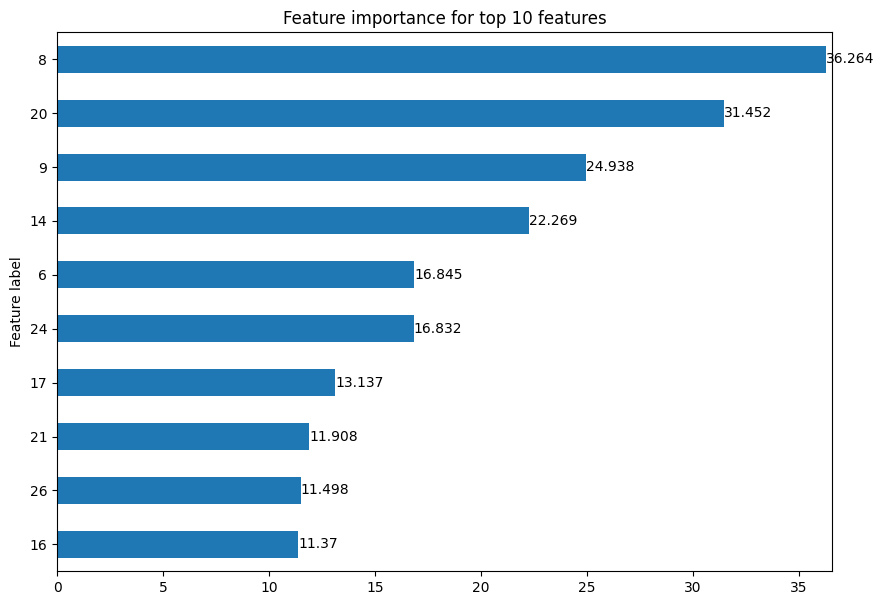

None

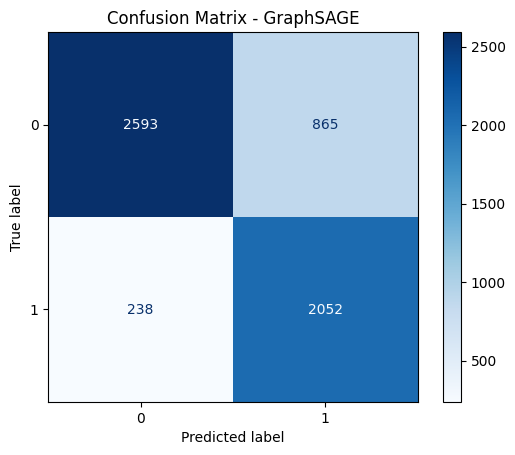

In [ ]:
#GraphSAGE 3
#keep this for result
test_acc, test_f1, model, _ = run_experiment_classification(data,'GraphSAGE',feat_cols,hidden_channels=64,lr=0.009092764903556424,dropout=0.4910661369759407,epochs=500)

### Hyperparameter

In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(lambda trial: objective_classification(trial, 'GCN', data, args), n_trials=500)
print("\nBest trial:")
print(f"  Value (1 - accuracy): {study.best_trial.value:.4f}")
print("  Best hyperparameters:")
for key, value in study.best_trial.params.items():
    print(f"    {key}: {value}")

[I 2025-06-12 16:20:50,933] A new study created in memory with name: no-name-bf9cb97c-c74a-48a7-918f-3831d22ed20b
[I 2025-06-12 16:20:51,071] Trial 0 finished with value: 0.3820459290187892 and parameters: {'hidden_channels': 64, 'lr': 0.000622341861841825, 'dropout': 0.5019099490144037}. Best is trial 0 with value: 0.3820459290187892.
[I 2025-06-12 16:20:51,212] Trial 1 finished with value: 0.4410229645093946 and parameters: {'hidden_channels': 32, 'lr': 0.0002869039390352668, 'dropout': 0.4555142196004715}. Best is trial 0 with value: 0.3820459290187892.
[I 2025-06-12 16:20:51,347] Trial 2 finished with value: 0.32045929018789143 and parameters: {'hidden_channels': 64, 'lr': 0.0028856856444261685, 'dropout': 0.4950827205691987}. Best is trial 2 with value: 0.32045929018789143.
[I 2025-06-12 16:20:51,484] Trial 3 finished with value: 0.44363256784968685 and parameters: {'hidden_channels': 16, 'lr': 0.0006497536061322568, 'dropout': 0.4687356146466169}. Best is trial 2 with value: 0.32


Best trial:
  Value (1 - accuracy): 0.2550
  Best hyperparameters:
    hidden_channels: 64
    lr: 0.008523295510961308
    dropout: 0.23044751904196414


In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(lambda trial: objective_classification(trial, 'GAT', data, args), n_trials=500)
print("\nBest trial:")
print(f"  Value (1 - accuracy): {study.best_trial.value:.4f}")
print("  Best hyperparameters:")
for key, value in study.best_trial.params.items():
    print(f"    {key}: {value}")

[I 2025-06-12 16:22:07,932] A new study created in memory with name: no-name-71345e4f-aead-42e0-9e8f-13ac51b4b2b1
[I 2025-06-12 16:22:08,269] Trial 0 finished with value: 0.3683020180932498 and parameters: {'hidden_channels': 16, 'lr': 0.0010836837949582978, 'dropout': 0.24012904646722322}. Best is trial 0 with value: 0.3683020180932498.
[I 2025-06-12 16:22:08,595] Trial 1 finished with value: 0.41701461377870563 and parameters: {'hidden_channels': 16, 'lr': 0.00018518776747019074, 'dropout': 0.4155661835576262}. Best is trial 0 with value: 0.3683020180932498.
[I 2025-06-12 16:22:09,152] Trial 2 finished with value: 0.36743215031315235 and parameters: {'hidden_channels': 64, 'lr': 0.001915462449488752, 'dropout': 0.4238770961516266}. Best is trial 2 with value: 0.36743215031315235.
[I 2025-06-12 16:22:09,482] Trial 3 finished with value: 0.3564718162839249 and parameters: {'hidden_channels': 32, 'lr': 0.008270335623737765, 'dropout': 0.4058184933105776}. Best is trial 3 with value: 0.3


Best trial:
  Value (1 - accuracy): 0.3427
  Best hyperparameters:
    hidden_channels: 32
    lr: 0.00529352947539645
    dropout: 0.2089373218331943


In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(lambda trial: objective_classification(trial, 'GraphSAGE', data, args), n_trials=500)
print("\nBest trial:")
print(f"  Value (1 - accuracy): {study.best_trial.value:.4f}")
print("  Best hyperparameters:")
for key, value in study.best_trial.params.items():
    print(f"    {key}: {value}")

[I 2025-06-12 16:25:07,765] A new study created in memory with name: no-name-0ec16fb9-1806-4ccb-8664-f0c4ce7f7585
[I 2025-06-12 16:25:07,958] Trial 0 finished with value: 0.5139178844815588 and parameters: {'hidden_channels': 16, 'lr': 0.0002810537468471202, 'dropout': 0.21410869569101126}. Best is trial 0 with value: 0.5139178844815588.
[I 2025-06-12 16:25:08,109] Trial 1 finished with value: 0.43493389004871263 and parameters: {'hidden_channels': 32, 'lr': 0.00013071051656052016, 'dropout': 0.5478367622829822}. Best is trial 1 with value: 0.43493389004871263.
[I 2025-06-12 16:25:08,259] Trial 2 finished with value: 0.31228253305497566 and parameters: {'hidden_channels': 16, 'lr': 0.002018088271867688, 'dropout': 0.27952489890120336}. Best is trial 2 with value: 0.31228253305497566.
[I 2025-06-12 16:25:08,405] Trial 3 finished with value: 0.2078983994432846 and parameters: {'hidden_channels': 64, 'lr': 0.009695221437663552, 'dropout': 0.558572156090152}. Best is trial 3 with value: 0.


Best trial:
  Value (1 - accuracy): 0.1942
  Best hyperparameters:
    hidden_channels: 64
    lr: 0.009092764903556424
    dropout: 0.4910661369759407


## EvolveGCN

### Result

[Ep 0001] loss 1.4045 | val-acc 0.4910
[Ep 0020] loss 11.3935 | val-acc 0.5090
[Ep 0040] loss 39.7108 | val-acc 0.5089
[Ep 0060] loss 23.3335 | val-acc 0.5889
[Ep 0080] loss 7.7175 | val-acc 0.6080
[Ep 0100] loss 9.1264 | val-acc 0.5029
[Ep 0120] loss 6.4320 | val-acc 0.5091
Early-stop @ 123

===== Final Test =====
              precision    recall  f1-score   support

           0     0.6669    0.2835    0.3978      3983
           1     0.6036    0.8851    0.7177      4909

    accuracy                         0.6156      8892
   macro avg     0.6352    0.5843    0.5578      8892
weighted avg     0.6319    0.6156    0.5744      8892

Acc 0.6156 | F1w 0.5744 | F1m 0.5578


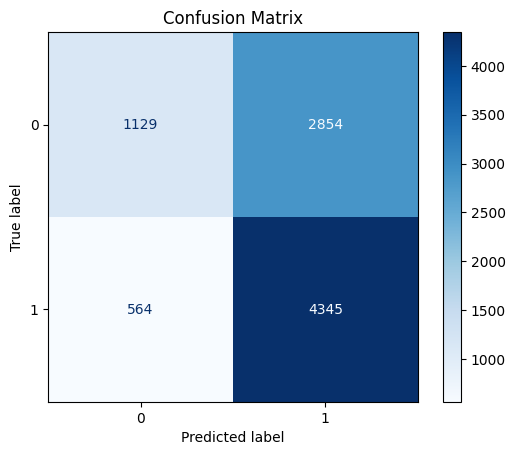

TypeError: _LastStepWrapper.forward() takes 2 positional arguments but 3 were given

In [ ]:
'''
feature_cols = None

snapshots, enc = build_snapshots_fast(
        df,
        time_col     ='timestamp_TW',
        uuid_col     ='uuid',
        label_col    ='proficient',
        snapshot_freq='W',
        feature_cols =feature_cols,
        edge_builder ='self',
        label_all    =True)

if feature_cols is None:
    feature_cols = df.select_dtypes(['number','bool']).columns.tolist()
'''
run_evolvegcn_experiment(
        snapshots,
        feature_names = feature_cols,
        hidden_dim=128,
        lr=1e-3,
        epochs=500,
        patience=30,
        train_ratio=0.6,
        val_ratio=0.2,
        explain=True,
        explain_k=10,
        node_idx=None,
        verbose_every =20)

### Try 2

In [ ]:
import numpy as np, pandas as pd, scipy.sparse as sp, copy, time,torch
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import NearestNeighbors
import torch.nn as nn
from torch.optim import Adam
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


def _normalize_sparse(adj: sp.spmatrix) -> sp.csr_matrix:
    """D^(-1/2) A D^(-1/2) ; in-place-safe & memory-light."""
    adj = adj + sp.eye(adj.shape[0], dtype=np.float32, format='csr')
    rowsum = np.asarray(adj.sum(1)).ravel()
    inv_sqrt = np.power(rowsum, -0.5, where=rowsum != 0).astype(np.float32)
    D_inv_sqrt = sp.diags(inv_sqrt)
    return D_inv_sqrt @ adj @ D_inv_sqrt


def build_snapshots_fast(
        df: pd.DataFrame,
        time_col='timestamp_TW',
        uuid_col='uuid',
        label_col='proficient',
        snapshot_freq='W',
        feature_cols=None,
        edge_builder='self',        # 'self' | 'knn'
        knn_k=5,
        dropna=True):
    """
    Return list of {time, adj, features, node_ids, labels}
    Much faster & lighter than the original one.
    """
    df = df.copy()
    df[time_col] = pd.to_datetime(df[time_col])
    df['snapshot'] = df[time_col].dt.to_period(snapshot_freq).dt.to_timestamp()

    if feature_cols is None:
        feature_cols = df.select_dtypes(['number', 'bool']).columns

    # numeric cast once, not per-snapshot
    df[feature_cols] = df[feature_cols].astype(np.float32)

    # Label-encode users
    enc = LabelEncoder()
    df['uid'] = enc.fit_transform(df[uuid_col])

    snapshots = []
    max_t = df['snapshot'].max()

    for t, grp in df.groupby('snapshot', sort=False):
        node_ids = grp['uid'].unique()
        node_ids.sort()                     # keep deterministic order
        idx_map = {u: i for i, u in enumerate(node_ids)}
        n = len(node_ids)

        # ==== build adjacency ===========================================
        if edge_builder == 'self':
            adj = sp.identity(n, dtype=np.float32, format='csr')   # O(1)
        elif edge_builder == 'knn':
            # k-NN on feature mean (small matrix) – still cheap
            X = (grp.groupby('uid')[feature_cols]
                     .mean()
                     .reindex(node_ids)
                     .fillna(0)
                     .to_numpy(np.float32))
            nbrs = NearestNeighbors(n_neighbors=min(knn_k + 1, n),
                                    metric='euclidean').fit(X)
            _, neigh = nbrs.kneighbors(X)
            row = np.repeat(np.arange(n), knn_k)
            col = neigh[:, 1:].reshape(-1)          # skip self idx 0
            data = np.ones_like(row, dtype=np.float32)
            adj = sp.coo_matrix((data, (row, col)), shape=(n, n),
                                dtype=np.float32).tocsr()
            adj = adj + adj.T                       # make symmetric
            adj.data[:] = 1.0
            adj = _normalize_sparse(adj)
        else:
            raise ValueError("edge_builder must be 'self' or 'knn'")

        if edge_builder == 'self':                  # normalize once
            adj = _normalize_sparse(adj)

        # ==== features ==================================================
        feats = (grp.groupby('uid')[feature_cols]
                 .mean()
                 .reindex(node_ids)
                 .fillna(0)
                 .to_numpy(np.float32))
        if dropna and np.isnan(feats).any():
            continue

        # ==== labels only for last snapshot =============================
        y = None
        if t == max_t:
            y = (grp.groupby('uid')[label_col]
                     .first()
                     .reindex(node_ids)
                     .to_numpy())

        snapshots.append(dict(time=t, adj=adj, features=feats,
                              node_ids=node_ids, labels=y))

        # optional: free memory per loop (good for big data)
        del grp, feats, adj

    return snapshots, enc

def _csr_to_torch_sparse_no_np(mat_csr, device='cpu'):
    """SciPy CSR → torch.sparse_coo_tensor，完全不用 torch.from_numpy()."""
    coo = mat_csr.tocoo()
    # ❶ 直接用 torch.tensor，把 numpy array 當普通 sequence 餵進去
    row = torch.tensor(coo.row, dtype=torch.int64, device=device)
    col = torch.tensor(coo.col, dtype=torch.int64, device=device)
    data = torch.tensor(coo.data, dtype=torch.float32, device=device)
    idx  = torch.stack([row, col])
    return torch.sparse_coo_tensor(idx, data, size=coo.shape).coalesce()


def run_evolvegcn_experiment(
        snapshots,
        hidden_dim=64,
        lr=1e-3,
        epochs=200,
        patience=30,
        track_micro=False,
        verbose_every=10):

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # -------- 尋找含標籤的最後 snapshot ----------------------------- ★
    try:
        label_idx = max(i for i, s in enumerate(snapshots)
                        if s['labels'] is not None)
    except ValueError:
        raise ValueError("No snapshot contains 'labels'. "
                         "Make sure you kept the final snapshot returned "
                         "by build_snapshots_fast().")

    # -------- Tensor list (至 label_idx) ---------------------------- ★
    X_list, A_list = [], []
    for s in snapshots[:label_idx + 1]:
        X_list.append(torch.tensor(s['features'], dtype=torch.float32,
                                   device=device))
        A_list.append(_csr_to_torch_sparse_no_np(s['adj'], device=device))

    raw = snapshots[label_idx]['labels']
    # 若是 float32 / Python 標量 → 轉成 1-D array；再轉 int64
    labels_np = (np.array([raw], dtype=np.int64, copy=False)
                if np.isscalar(raw)
                else np.asarray(raw, dtype=np.int64))
    final_labels = torch.tensor(labels_np, dtype=torch.long, device=device)

    num_classes = int(final_labels.max().item()) + 1
    model = EvolveGCN_H(X_list[0].shape[1], hidden_dim, num_classes).to(device)
    optimizer = Adam(model.parameters(), lr=lr)
    loss_fn   = nn.CrossEntropyLoss()

    best_acc, best_weights, no_gain = 0.0, None, 0
    to_list = lambda t: t.detach().cpu().tolist()

    # -------- Training loop ----------------------------------------
    for epoch in range(1, epochs + 1):
        model.train()
        optimizer.zero_grad()
        logits = model(X_list, A_list)
        loss   = loss_fn(logits, final_labels)
        loss.backward()
        optimizer.step()

        # ---- metrics ------------------------------------------------
        model.eval()
        with torch.no_grad():
            preds  = logits.argmax(dim=1)
            acc    = accuracy_score(to_list(final_labels), to_list(preds))
            f1_w   = f1_score(to_list(final_labels), to_list(preds),
                              average='weighted')
            f1_m   = f1_score(to_list(final_labels), to_list(preds),
                              average='macro')
            f1_u   = (f1_score(to_list(final_labels), to_list(preds),
                               average='micro') if track_micro else None)

        # ---- early-stop logic ---------------------------------------
        if acc > best_acc:
            best_acc, best_weights = acc, copy.deepcopy(model.state_dict())
            no_gain = 0
        else:
            no_gain += 1
            if patience and no_gain >= patience:
                print(f"Early stop at epoch {epoch} (no gain for {patience})")
                break

        if epoch % verbose_every == 0 or epoch == 1:
            msg = (f"[EvolveGCN] Ep {epoch:04d} | Loss {loss:.4f} "
                   f"| Acc {acc:.4f} | F1w {f1_w:.4f} | F1m {f1_m:.4f}")
            if track_micro:
                msg += f" | F1µ {f1_u:.4f}"
            print(msg)

    # -------- Final eval -------------------------------------------
    model.load_state_dict(best_weights)
    model.eval()
    with torch.no_grad():
        logits = model(X_list, A_list)
        preds  = logits.argmax(dim=1)

    acc   = accuracy_score(to_list(final_labels), to_list(preds))
    f1_w  = f1_score(to_list(final_labels), to_list(preds), average='weighted')
    f1_m  = f1_score(to_list(final_labels), to_list(preds), average='macro')
    f1_u  = (f1_score(to_list(final_labels), to_list(preds),
                      average='micro') if track_micro else None)

    print("\n[EvolveGCN] ===== Final Report =====")
    print(classification_report(to_list(final_labels), to_list(preds), digits=4))
    print(f"Acc {acc:.4f} | F1w {f1_w:.4f} | F1m {f1_m:.4f}"
          + (f" | F1µ {f1_u:.4f}" if track_micro else ""))

    cm = confusion_matrix(to_list(final_labels), to_list(preds))
    ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap=plt.cm.Blues)
    plt.title("EvolveGCN – Confusion Matrix")
    plt.savefig("evolvegcn_confusion_matrix.png", dpi=200, bbox_inches="tight")
    plt.show()

    res = dict(acc=acc, f1_weighted=f1_w, f1_macro=f1_m, model=model)
    if track_micro:
        res['f1_micro'] = f1_u
    return res

[EvolveGCN] Ep 0001 | Loss 6.9673 | Acc 0.5015 | F1w 0.3350 | F1m 0.3340
[EvolveGCN] Ep 0010 | Loss 403.5964 | Acc 0.4985 | F1w 0.3317 | F1m 0.3327
[EvolveGCN] Ep 0020 | Loss 99.5440 | Acc 0.5098 | F1w 0.3657 | F1m 0.3666
[EvolveGCN] Ep 0030 | Loss 49.8589 | Acc 0.5015 | F1w 0.3350 | F1m 0.3340
[EvolveGCN] Ep 0040 | Loss 55.5211 | Acc 0.4985 | F1w 0.3317 | F1m 0.3327
[EvolveGCN] Ep 0050 | Loss 64.0024 | Acc 0.5020 | F1w 0.3361 | F1m 0.3351
[EvolveGCN] Ep 0060 | Loss 17.5424 | Acc 0.5015 | F1w 0.3350 | F1m 0.3340
[EvolveGCN] Ep 0070 | Loss 100.0030 | Acc 0.5015 | F1w 0.3350 | F1m 0.3340
[EvolveGCN] Ep 0080 | Loss 52.9966 | Acc 0.5024 | F1w 0.3534 | F1m 0.3543
Early stop at epoch 81 (no gain for 30)

[EvolveGCN] ===== Final Report =====
              precision    recall  f1-score   support

           0     0.6314    0.6798    0.6547      1018
           1     0.6554    0.6055    0.6294      1024

    accuracy                         0.6425      2042
   macro avg     0.6434    0.6426    

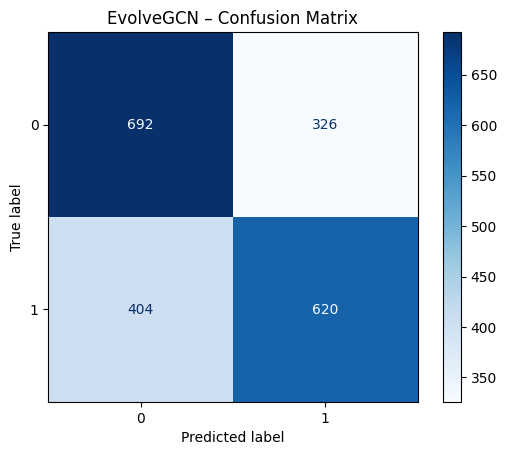

{'acc': 0.6425073457394711,
 'f1_weighted': 0.6420252614125217,
 'f1_macro': 0.6420623448222871,
 'model': EvolveGCN_H(
   (layer1): EvolveGCNLayerH(
     (gru): GRUCell(4864, 4864)
   )
   (layer2): EvolveGCNLayerH(
     (gru): GRUCell(256, 256)
   )
 )}

In [ ]:
snapshots, uuid_encoder = build_snapshots_fast(
        df,
        time_col='timestamp_TW',
        uuid_col='uuid',
        label_col='proficient',
        snapshot_freq='W',
        feature_cols=None,
        edge_builder='self',
        knn_k=5,
        dropna=True)
run_evolvegcn_experiment(
        snapshots,
        hidden_dim=128,
        lr=1e-3,
        epochs=500,
        patience=30,
        track_micro=False,
        verbose_every=10)

[EvolveGCN] Ep 0001 | Loss 4.2498 | Acc 0.5455 | F1w 0.3850 | F1m 0.3529
[EvolveGCN] Ep 0010 | Loss 122.5417 | Acc 0.4545 | F1w 0.2841 | F1m 0.3125
[EvolveGCN] Ep 0020 | Loss 40.1566 | Acc 0.6364 | F1w 0.6169 | F1m 0.6071
[EvolveGCN] Ep 0030 | Loss 79.0007 | Acc 0.4545 | F1w 0.2841 | F1m 0.3125
[EvolveGCN] Ep 0040 | Loss 16.0331 | Acc 0.6364 | F1w 0.6169 | F1m 0.6071
[EvolveGCN] Ep 0050 | Loss 44.1124 | Acc 0.4545 | F1w 0.2841 | F1m 0.3125
Early stop at epoch 53 (no gain for 30)

[EvolveGCN] ===== Final Report =====
              precision    recall  f1-score   support

           0     0.6250    0.8333    0.7143         6
           1     0.6667    0.4000    0.5000         5

    accuracy                         0.6364        11
   macro avg     0.6458    0.6167    0.6071        11
weighted avg     0.6439    0.6364    0.6169        11

Acc 0.6364 | F1w 0.6169 | F1m 0.6071


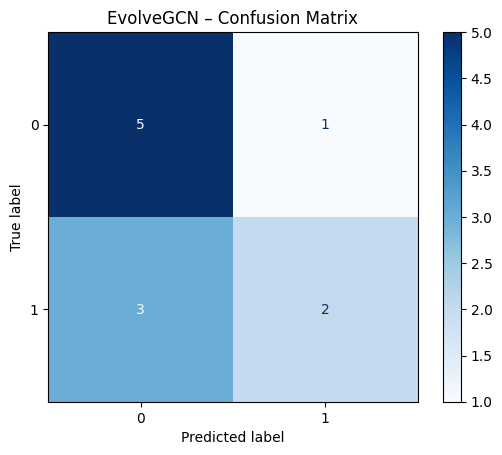

{'acc': 0.6363636363636364,
 'f1_weighted': 0.6168831168831169,
 'f1_macro': 0.6071428571428572,
 'model': EvolveGCN_H(
   (layer1): EvolveGCNLayerH(
     (gru): GRUCell(4864, 4864)
   )
   (layer2): EvolveGCNLayerH(
     (gru): GRUCell(256, 256)
   )
 )}

In [ ]:
snapshots, uuid_encoder = build_snapshots_fast(
        df,
        time_col='timestamp_TW',
        uuid_col='uuid',
        label_col='proficient',
        snapshot_freq='M',
        feature_cols=None,
        edge_builder='self',
        knn_k=5,
        dropna=True)
run_evolvegcn_experiment(
        snapshots,
        hidden_dim=128,
        lr=1e-3,
        epochs=500,
        patience=30,
        track_micro=False,
        verbose_every=10)

### Try 1

In [ ]:
snapshot, uuid_encoder = build_snapshots(df, time_col='timestamp_TW', uuid_col='uuid',label_col='proficient', snapshot_freq='W',feature_cols=None, dropna=True)
'''
num_classes = df['points_class'].nunique()
best_params = run_optuna_evolvegcn(snapshot, num_classes, n_trials=20)
print(best_params)
'''

"\nnum_classes = df['points_class'].nunique()\nbest_params = run_optuna_evolvegcn(snapshot, num_classes, n_trials=20)\nprint(best_params)\n"

[EvolveGCN] Epoch 001 | Loss: 4.6678 | Acc: 0.5000 | F1-w: 0.3350 | F1-m: 0.3359
[EvolveGCN] Epoch 010 | Loss: 170.6434 | Acc: 0.5005 | F1-w: 0.3411 | F1-m: 0.3421
[EvolveGCN] Epoch 020 | Loss: 73.8338 | Acc: 0.5069 | F1-w: 0.3603 | F1-m: 0.3612
[EvolveGCN] Epoch 030 | Loss: 36.3162 | Acc: 0.6107 | F1-w: 0.5990 | F1-m: 0.5992
[EvolveGCN] Epoch 040 | Loss: 25.8214 | Acc: 0.5054 | F1-w: 0.3453 | F1-m: 0.3444
[EvolveGCN] Epoch 050 | Loss: 8.2169 | Acc: 0.5656 | F1-w: 0.5186 | F1-m: 0.5181
[EvolveGCN] Epoch 060 | Loss: 10.4683 | Acc: 0.6352 | F1-w: 0.6336 | F1-m: 0.6337
[EvolveGCN] Epoch 070 | Loss: 19.6695 | Acc: 0.5020 | F1-w: 0.3401 | F1-m: 0.3411
[EvolveGCN] Epoch 080 | Loss: 21.0133 | Acc: 0.4985 | F1-w: 0.3326 | F1-m: 0.3335
[EvolveGCN] Epoch 090 | Loss: 4.8695 | Acc: 0.6229 | F1-w: 0.6208 | F1-m: 0.6209
[EvolveGCN] Epoch 100 | Loss: 28.8626 | Acc: 0.5015 | F1-w: 0.3350 | F1-m: 0.3340
[EvolveGCN] Epoch 110 | Loss: 11.7529 | Acc: 0.6596 | F1-w: 0.6594 | F1-m: 0.6593
[EvolveGCN] Epoch 

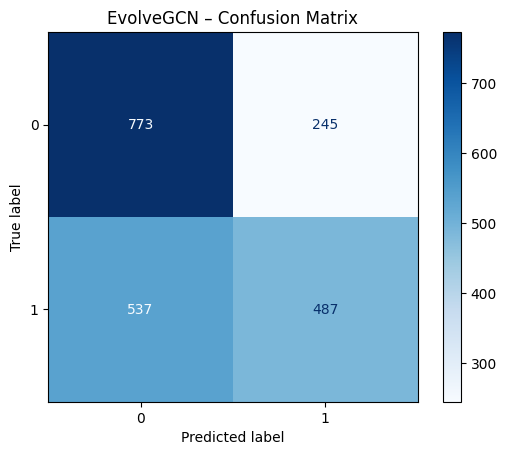

In [ ]:
num_classes = df['proficient'].nunique()
result = run_evolvegcn_experiment(snapshot,num_classes,hidden_dim=32,lr=0.0064761652479616676,epochs=200)